### Title




The Interdisciplinarity of TED Talks, a Network Perspective 

### Inproduction
 

Interdisciplinarity generally means the combination or integration of knowledge from different specialties. People now believe that interdisciplinarity can bring added value as they believe the total is greater and more interesting than the sum of parts. So far we have found increasing levels of interdisciplinarity in all kinds of knowledge-intensive organizations and platforms such as high-tech companies, academic institutions and research centers.  In this paper, we turn to TED, a nonprofit platform to spread ideas usually in the form of short talks. 

TED talks are garnering public's attention these years with all kinds of interesting topics. For now, 449 topic keywords have been listed on [TED's website](https://www.ted.com/topics) which have covered almost every aspect of human life. We notice each talk published on the website involves more than one topic keyword labeled by the publisher, and for some talks the list of keywords includes topics from several different domains, which implies the interdisciplinary nature of these talks. So how can we measure the interdisciplinarity of TED talks based on its list of topic keywords? What is TED talks’ trend of interdisciplinarity measured at different granularities? In addition, is there any relationship between the talk interdisciplinarity and viewers' response?

In the thesis we propose several metrics for interdisciplinarity measurement at different granularities by means of LDA topic modeling and network analysis. 
1. First, we identify a few major categories for TED talks by applying the LDA topic model to their lists of topic keywords, which generates one major category distribution for each TED talk. 
2. Based on the major category distribution, we score each talk's interdisciplinarity using the pvalue from the Chi-square test. 
3. Next we build a network of talks based on the similarity of every two talks' major category distributions and detect clusters in the network with one cluster corresponding to one major category, and then
4. We compute the similarity ratios define as the inter-cluster similarity over the intra-cluster similarity between every two clusters, a metric of interdisciplinarity measured for one major category related to another major category. 
5. Using this metric we divide TED talks by year to examine the temporal trend of similarity between every pair of major categories.  

We also explore the relationship between the popularity and the interdisciplinarity measured at the major category level. We use the average number of comments indicating the major category's popularity instead of the number of views, because the former is more related to the talk content and comments are often made after watching the whole video thus more indicative of the genuine popularity. For another interdisciplinarity measurement at the major category level, we take a new  approach as follows: 
1. First choose a relatively large number of major categories and build one network for each year based on similarity between talk distributions on major categories, and use Louvain algorithm to detect the clusters in each network as before to examine which major categories more often appear in one cluster and how the major category members in each cluster change in different years. 
2. Based on how many times every pair of major categories falls into one cluster over years, build a new network with nodes of major category and edges weighted by number of times sharing one cluster, and then 
3. Examine the relationship between two metrics of node centrality in the network and the average number of comments for each major category respectively. 

### Data preprocessing

We download the dataset from [Kaggle page](https://www.kaggle.com/rounakbanik/ted-talks/version/3#ted_main.csv) which consists of meta data about 2550 TED talks from year 2005 to 2017. Later we will try scraping data directly from [TED website](https://www.ted.com).

In [110]:
import numpy as np
import pandas as pd
ted = pd.read_csv("ted_metadata_kaggle.csv") 
print(ted.shape)
print(ted.columns)

(2550, 19)
Index(['Unnamed: 0', 'comments', 'description', 'duration', 'event',
       'film_date', 'languages', 'main_speaker', 'name', 'num_speaker',
       'published_date', 'ratings', 'related_talks', 'speaker_occupation',
       'tags', 'title', 'url', 'views', 'vidID_youtube'],
      dtype='object')


Dataframe ted contains meta data from 2550 TED talks filmed from year 2005 to 2017. We first split the dataset into 6 subsets based on the "film_date" column of the dataframe. All dates in the column takes the Unix timestamp format, so we need to convert them to the datetime format and retrieve years of interest. 

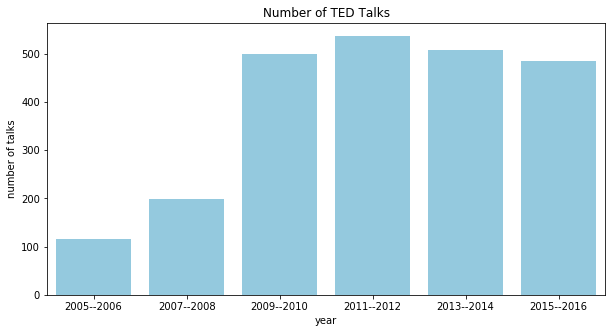

In [111]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
yvect = ted.film_date.apply(lambda x: datetime.datetime.fromtimestamp(int(x)).year)
#syear = 2005
#sns.distplot(yvect)
teds = [ted[(yvect==year)|(yvect==year+1)] for year in range(2005,2017,2)] 
# check the number of talks for each group
xmarks = [str(year) + "--" + str(year+1) for year in range(2005,2017,2)]
plt.figure(figsize=(10,5))
sns.barplot(x=xmarks, y=list(map(len,teds)),color='skyblue').set_title("Number of TED Talks")
plt.xlabel('year')
plt.ylabel('number of talks')
plt.show()




From the graph we can see the numbers of talks from year 2005 to year 2008 are relatively small, so we group all years'data before 2009 as one subset and the rest are grouped bianually except for the last group where we also include data from year 2017.

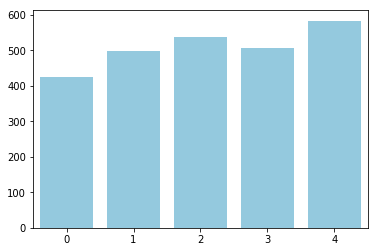

2017

In [114]:
ted_05_08 = ted[yvect<2009]
ted_09_10 = ted[(yvect==2009) | (yvect==2010)]
ted_11_12 = ted[(yvect==2011) | (yvect==2012)]
ted_13_14 = ted[(yvect==2013) | (yvect==2014)]
ted_15_17 = ted[yvect>=2015]
teds = [ted_05_08,ted_09_10,ted_11_12,ted_13_14,ted_15_17]
sns.barplot(x=list(range(len(teds))), y=list(map(len,teds)),color='skyblue')
plt.show()
max(yvect)

Not all columns in each dataframe are relevant. To measure the popularity, we need two columns 'comments'and 'views', and for the topic information we only need column 'tags'.

In [930]:
data_list = [ted[['comments','views','tags']] for ted in teds]
data_list = [ted.reset_index() for ted in data_list]
for data in data_list:
    data['index'] = data['index'].apply(lambda x:str(x))
    data.columns = ['id', 'comments', 'views', 'tags']
ted_data = pd.concat([data_list[0],data_list[1],data_list[2],data_list[3],data_list[4]])
period = [ [i]*len(data_list[i]) for i in range(5)]
ted_data['year'] = yvect.tolist()
ted_data['period']=period[0]+period[1]+period[2]+period[3]+period[4]


### Classification with two major categories

Next we apply LDA topic modeling to column 'tags'. First we notice each talk in each time period is labeled with more than one topic, and some topics are more popular than other topics in terms of number of talks tagging the topic. So we can draw the topic popularity using a word cloud and check the top 10 popular topics:  

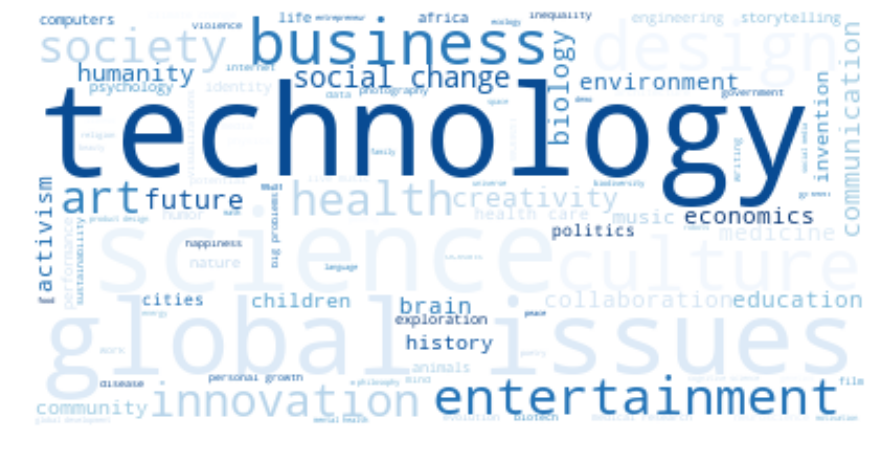

Top 10 Topics:
[   ('technology', 727),
    ('science', 567),
    ('global issues', 501),
    ('culture', 486),
    ('design', 418),
    ('business', 348),
    ('entertainment', 299),
    ('health', 236),
    ('innovation', 229),
    ('society', 224)]
Total number of topics:  404


In [6]:
from wordcloud import WordCloud
import pprint

topic_freq = {}
def addWeight(lst, topic_freq):
    for topic in lst:
        # remove topics not relevant to classification
        if not topic.startswith("TED") and not topic.startswith('MacArthur'):
            topic = topic.lower()
            if topic not in topic_freq:
                topic_freq[topic] = 0
            topic_freq[topic]+=1
for lst in ted_data.tags:
    addWeight(eval(lst),topic_freq)
    
wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      colormap='Blues').generate_from_frequencies(topic_freq)

fig = plt.figure(1,figsize=(15,15))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()
sorted_topics = sorted(topic_freq.items(),key=lambda x:x[1],reverse=True)[:10]
pp = pprint.PrettyPrinter(indent = 4)
print("Top 10 Topics:")
pp.pprint(sorted_topics)
print("Total number of topics: ",len(topic_freq))



404 topics are way too many for us, and we need to classify them into fewer major categories and check to what extent each talk belongs to each major categories. To apply LDA topic modeling, we use each list of topics for one talk as one document, and run the LDA algorithms on all documents to identify the major categories.  

In [1300]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel

#first we filter out topics starting with 'TED' and 'MacArthur grant' which
#are less relevant for topic classification.
def clean(lst):
    return [elem.lower() for elem in lst if not elem.startswith('MacArthur grant') and not elem.startswith('TED')]
texts = list(map(clean,[eval(lst) for lst in ted_data['tags'].tolist()]))

#Now we apply LDA topic modeling to all topic texts.
#First build a Dictionary and corpus from the list of words
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


Now it is almost ready to build the LDA model, but before that we need set three important parameters for LDA topic modeling: number of topics, number of words shown for each topic, and the number of iterations the algorithm runs. Generally, more topics with fewer words for each topic could have better results, and a larger number of iterations would reduce the randomness inherent in the LDA modeling algorithm. Here we try different numbers of topics and choose the one with high coherence score with passes = 20.

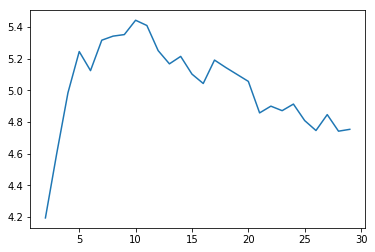

In [1112]:
number_topics = list(range(2,30))
coherences = [0]*len(number_topics)
for i in range(10):
    for num_topic in number_topics:
        lda = LdaModel(corpus, id2word = dictionary,
                       num_topics = num_topic,
                       passes = passes)
        coherence_model_lda = CoherenceModel(model=lda, 
                                         texts=texts, 
                                         dictionary=dictionary, 
                                         coherence='c_v')
        coherences[num_topic-2]+=coherence_model_lda.get_coherence()
    
plt.plot(number_topics, coherences)
plt.show()

From the graph above we can see that the curve gets the global optimal when num_topics = 10. But before that, we first consider a broader classification by choosing 2 major categories which we expect to correspond to the 'natrual' aspects and the 'social' aspects respectively.

In [932]:
num_topic = 2 
coherences = []
ldas = []
for i in range(100):
    lda = LdaModel(corpus, id2word = dictionary,
                       num_topics = num_topic,
                       passes = passes)
    coherence_model_lda = CoherenceModel(model=lda, 
                                         texts=texts, 
                                         dictionary=dictionary, 
                                         coherence='c_v')
    coherences.append(coherence_model_lda.get_coherence()) 
    ldas.append(lda)


We choose the best lda model among 100 trials by picking the one with the highest model coherence score, and check keywords for each major topic: 

In [933]:
lda = ldas[coherences.index(max(coherences))]
pp = pprint.PrettyPrinter(indent = 4)
pp.pprint(lda.print_topics(num_words = number_words))

[   (   0,
        '0.055*"technology" + 0.052*"science" + 0.033*"design" + '
        '0.031*"innovation" + 0.023*"future" + 0.019*"environment" + '
        '0.018*"nature" + 0.018*"creativity" + 0.018*"biology" + 0.017*"art" + '
        '0.016*"invention" + 0.015*"brain" + 0.014*"engineering" + '
        '0.013*"exploration" + 0.011*"computers" + 0.011*"health" + '
        '0.011*"collaboration" + 0.010*"visualizations" + 0.010*"beauty" + '
        '0.010*"animals"'),
    (   1,
        '0.039*"society" + 0.032*"global issues" + 0.031*"social change" + '
        '0.026*"communication" + 0.025*"humanity" + 0.022*"community" + '
        '0.022*"business" + 0.020*"identity" + 0.020*"culture" + '
        '0.018*"activism" + 0.017*"personal growth" + 0.015*"economics" + '
        '0.015*"children" + 0.015*"inequality" + 0.014*"government" + '
        '0.013*"health" + 0.013*"collaboration" + 0.013*"women" + 0.012*"big '
        'problems" + 0.011*"politics"')]


So we can see the first major topic is mainly about technology, design and natural science while the second is mainly about society, culture and social change, which intuitively makes sense. We can save this model for later use. 

In [936]:
#lda.save('lda2.gensim')
lda_2 = lda.load('lda2.gensim',mmap='r')

Next we apply the topic model to each talk's list of topic keywords:

In [937]:
topic_ids = ted_data['id'].tolist()
topic_scores = [lda_2[ncorpus] for ncorpus in [dictionary.doc2bow(text) for text in texts]]
# some tweaks on score format
def add_zeros(topic_lst,n):
    topic_ids = set([t[0] for t in topic_lst])
    for i in range(n):
        if not i in topic_ids:
            topic_lst.insert(i, (i,0))
    return topic_lst
major_topics = list(map(add_zeros,topic_scores,[num_topic]*len(topic_scores)))
ted_data['topics'] = major_topics
pp = pprint.PrettyPrinter()
pp.pprint(major_topics[:3])
for i in range(3):
    print(ted_data['tags'].tolist()[i])

[[(0, 0.14212145), (1, 0.85787857)],
 [(0, 0.8869085), (1, 0.11309151)],
 [(0, 0.6080873), (1, 0.3919127)]]
['children', 'creativity', 'culture', 'dance', 'education', 'parenting', 'teaching']
['alternative energy', 'cars', 'climate change', 'culture', 'environment', 'global issues', 'science', 'sustainability', 'technology']
['computers', 'entertainment', 'interface design', 'media', 'music', 'performance', 'simplicity', 'software', 'technology']


For the first 3 talks' major topic classification, we see the first talk is more focused on the second major topic by checking against its list of keyword topics, corresponding to the heavy weight 0.85787857 on the second major topic compared with the much smaller weight 0.14212145 on the first. In contrast, the second talk is more on the first major topic although one of its keyword topics 'global issues' belongs to the second major topic, which results in a small but non-trivial weight of 0.11309151 on the second major topic. 

More interesting is the third talk almost equally weighted on both major topics, which is indicated by its list of keyword topics containing not only 'computers', 'interface design', 'software', 'technology' which clearly belongs to the first major topics but also 'entertainment','media', 'music', 'performance' from the second major topic. Here we define such talks with roughly equal weights on both major topics as interdisciplinary talks, and we want to identify some temporal trends for such interdisciplinary TED talks using network analysis. 

But first we want to define a metric to measure the interdisciplinarity, we can borrow the chi-square test statistic with the expected frequency distribution of (0.5, 0.5), and the interdisciplinarity score for each talk can be defined as the pvalue of  the chi-square test statistic:




$$inter\_score = pvalue(\chi^2(\sum_{i=1}^{2}\frac {(e_{i}-weight_{i})^2}{e_{i}},DOF=2-1))$$


where $e_{i} = 1/2$



In [938]:
from scipy.stats import *

def compute_interscore(w,n):
    expected = [1/n]*n
    weights = [(t[1]) for t in w]
    return chisquare(weights,expected).pvalue

ted_data['inter_score_2'] = [compute_interscore(talk_weight,2) for talk_weight in major_topics]
ted_data['inter_score_2'].head(3)

0    0.474141
1    0.439039
2    0.828852
Name: inter_score_2, dtype: float64

So we can see the second talk is least interdisciplinary with the lowest interdisciplinarity score among the three while the third talk is most interdisciplinary with the highest score. Next we want to see if any temporal trend exists in terms of the interdisciplinarity score. Due to the small numbers of talks filmed in those years. We zoom in to check the trend starting from year 2009:

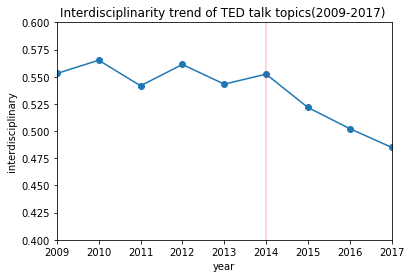

In [942]:
plt.plot(ted_data.groupby('year')['inter_score_2'].mean())
plt.scatter(range(2009,2018),ted_data.groupby('year')['inter_score_2'].mean()[-9:])
plt.xlabel('year')
plt.xlim([2009,2017])
plt.ylim([0.4,0.6])
plt.axvline(x=2014,color='r',alpha=0.2)
plt.ylabel('interdisciplinary')
plt.title('Interdisciplinarity trend of TED talk topics(2009-2017) ')
plt.show()

We can see a relatively stable period from year 2009 to 2014, but from year 2015, the downward trend is obvious. The trend indicates TED talks are becoming less interdisciplinary recently, which is a bit counter-intuitive, but remember the interdisciplinary score is defined between two broad categories. Maybe we should try a topic categorization with greater granularity, or with larger number of major topics. 

But before that, we want to model the topic similarity between TED talks by using a network, and confirm the observed trend using some network metrics.    

To build the network, we first need to compute the similarity between talks in terms of their weights on both major topics: each talk's major topic weights can be seen as a vector, and to measure the similarity of any two talks, we only need to compute the cosine value of the angle between the two corresponding vectors:

$$COS (\theta_{\bar a_{1},\bar a_{2}}) = (\frac {\bar a_{1}\cdot \bar a_{2}}{|\bar a_{1}||\bar a_{2}|})$$

For our purpose of building a network, the cosine value can be assigned to the edge between the two relevant talks as the edge weight. In this way, we construct a network with nodes of talks and edges labeled with the similarity measure defined above. 

After building the network as above, we use the Louvain method which has been implemented in the Python library community to identify the clusters from the resulting weighted network, and expect to find 2 clusters which correspond to the two major catogories. Then we draw the graph using the spring layout with interdisciplinary score of each talk indicated by the node size.
  

In [949]:
import networkx as nx
import community
import matplotlib.pyplot as plt



def dot_product(lst1,lst2):
    score1 = [np.around(t[1],6) for t in lst1]
    score2 = [np.around(t[1],6) for t in lst2]
    return sum(np.array(score1)*np.array(score2))

def build_network(ted_data,year,threshold):
    data_period = ted_data if year==-1 else ted_data[ted_data['year']==year]
    #data_period = ted_data[ted_data['year']==year]
    length = len(data_period)
    talk_ids = data_period['id'].tolist()
    edge_list=[]
    for i in range(length):
        for j in range(i+1,length):
            weight = dot_product(data_period['topics'].tolist()[i],data_period['topics'].tolist()[j])
            if weight > threshold:
                edge_list.append((str(data_period['id'].tolist()[i]),str(data_period['id'].tolist()[j]),weight))
    g = nx.Graph()
    g.add_nodes_from(list(map(str,talk_ids)))
    g.add_weighted_edges_from(edge_list)
    return g

def draw_network_2(g,data_period,threshold):
    # identify communities in network using Louvain method
    partition = community.best_partition(g)
    
    color=['red','blue']
    plt.figure(figsize=(30,30))
    rednodes = [t[0] for t in partition.items() if t[1]==0]
    bluenodes = [t[0] for t in partition.items() if t[1]==1]
    red_sizes = [data_period.set_index('id')['inter_score_2'][node]*3000 for node in rednodes]
    blue_sizes = [data_period.set_index('id')['inter_score_2'][node]*3000 for node in bluenodes]
    pos = nx.spring_layout(g)
    nx.draw_networkx_nodes(g,pos=pos,node_size = red_sizes,nodelist=rednodes, node_color='red', label='TED talks on society, culture and social change')
    nx.draw_networkx_nodes(g,pos=pos,node_size = blue_sizes,nodelist=bluenodes, node_color='blue', label='TED talks on technology, design and natural science')
    nx.draw_networkx_edges(g,pos=pos)
    nx.draw_networkx_labels(g,pos=pos)
    plt.legend(loc = 0, ncol = 1,prop={'size': 30})
    plt.title("TED talk network with two major topic categories threshold = "+str(threshold),size=40)
    plt.show()

def compute_ratio(g):
    partition = community.best_partition(g)
    # compare the 'cohesion' for within-cluster talks 
    # with the 'coupling' for between-cluster talks
    graph_reduced= community.induced_graph(partition, g)
    within_cluster = graph_reduced[0][0]['weight']+graph_reduced[1][1]['weight']
    between_cluster = graph_reduced[0][1]['weight']
    return 2*between_cluster/within_cluster
      

First we build a network using all data, and reduce the network to 2 clusters corresponding to the two major categories, and take the ratio of 2 times the summed weight over all inter-cluster edges,the 'coupling', and the summed weight over all intra-cluster edges, the 'cohesion',which is another metric to measure the overall similarity between all talks in the first category and ones in the second. So this new metric of 'coupling' over 'cohesion' ratio is more focused on similarity between talks in two categories, which to some extent reflects the the overall interdisciplinarity level for all TED talks:
$$ sim\_ratio = \frac{2*inter\_node\_edge\_weight}{(intra\_node\_edge\_weight1+intra\_node\_edge\_weight2)}$$

In [955]:
#build a network of all TED talks
g_2 = build_network(ted_data,-1,0)


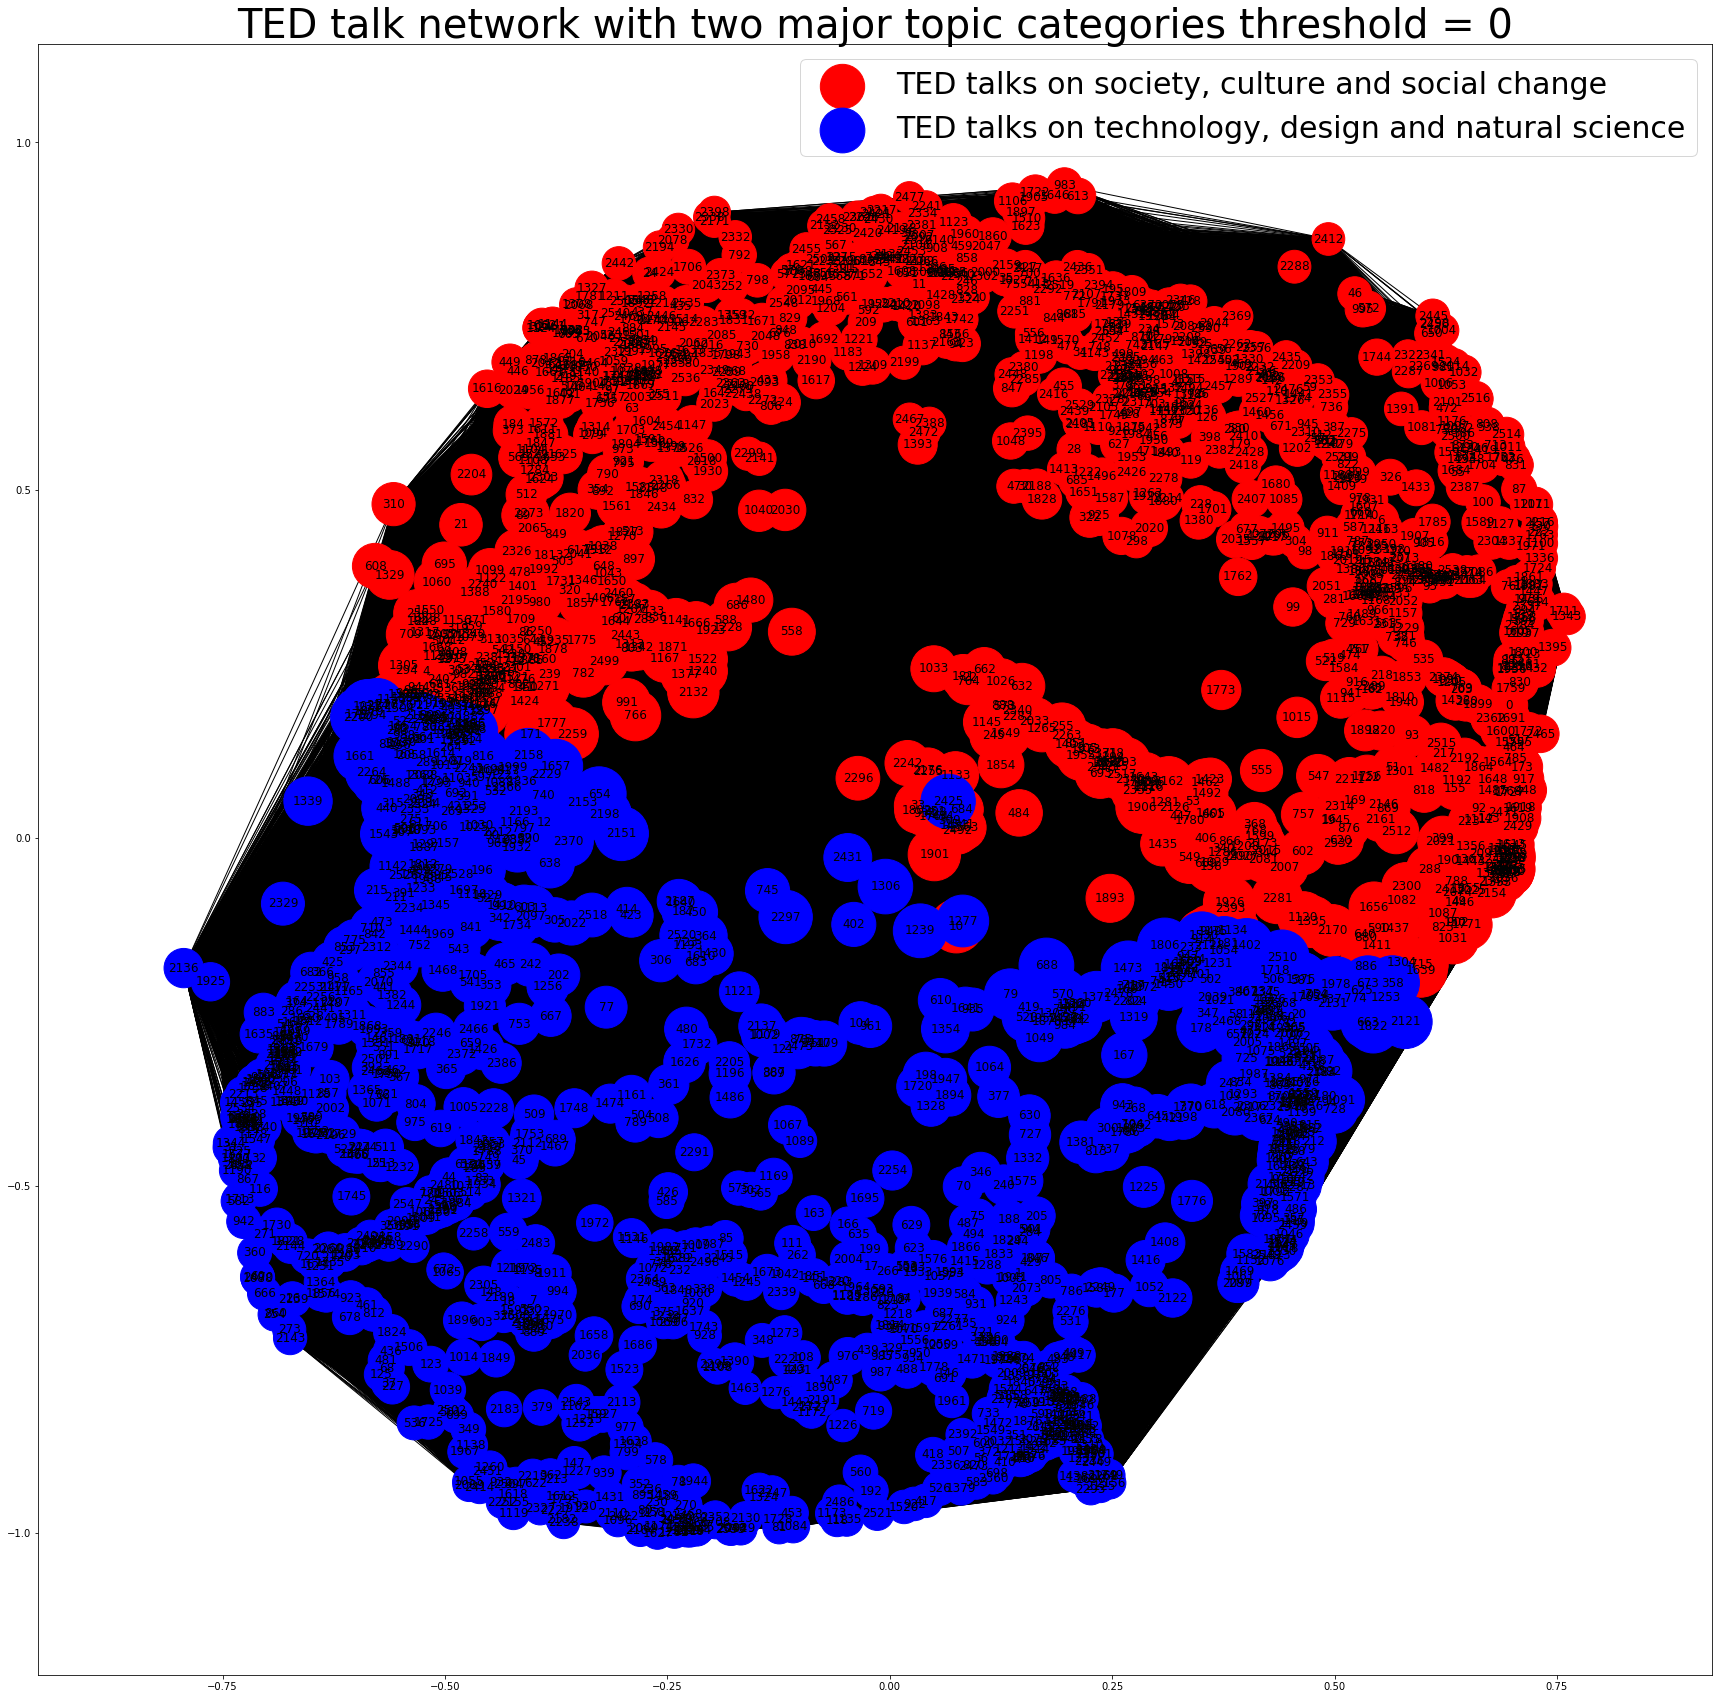

In [956]:
draw_network_2(g_2,ted_data,0)


We can see from the network above that talks classified into two major categories are clearly positioned on two sides of the network. The talk nodes near the boundary have larger size than those far from the boundary, which indicates that nodes with high interdisciplinarity score in one category are closer to nodes from the other category. 

To meausre the similarity ratio mentioned above, next we reduced the original newtork with threshold = 0 into two nodes for the two major categories: "society+culture" and "nature+technology".

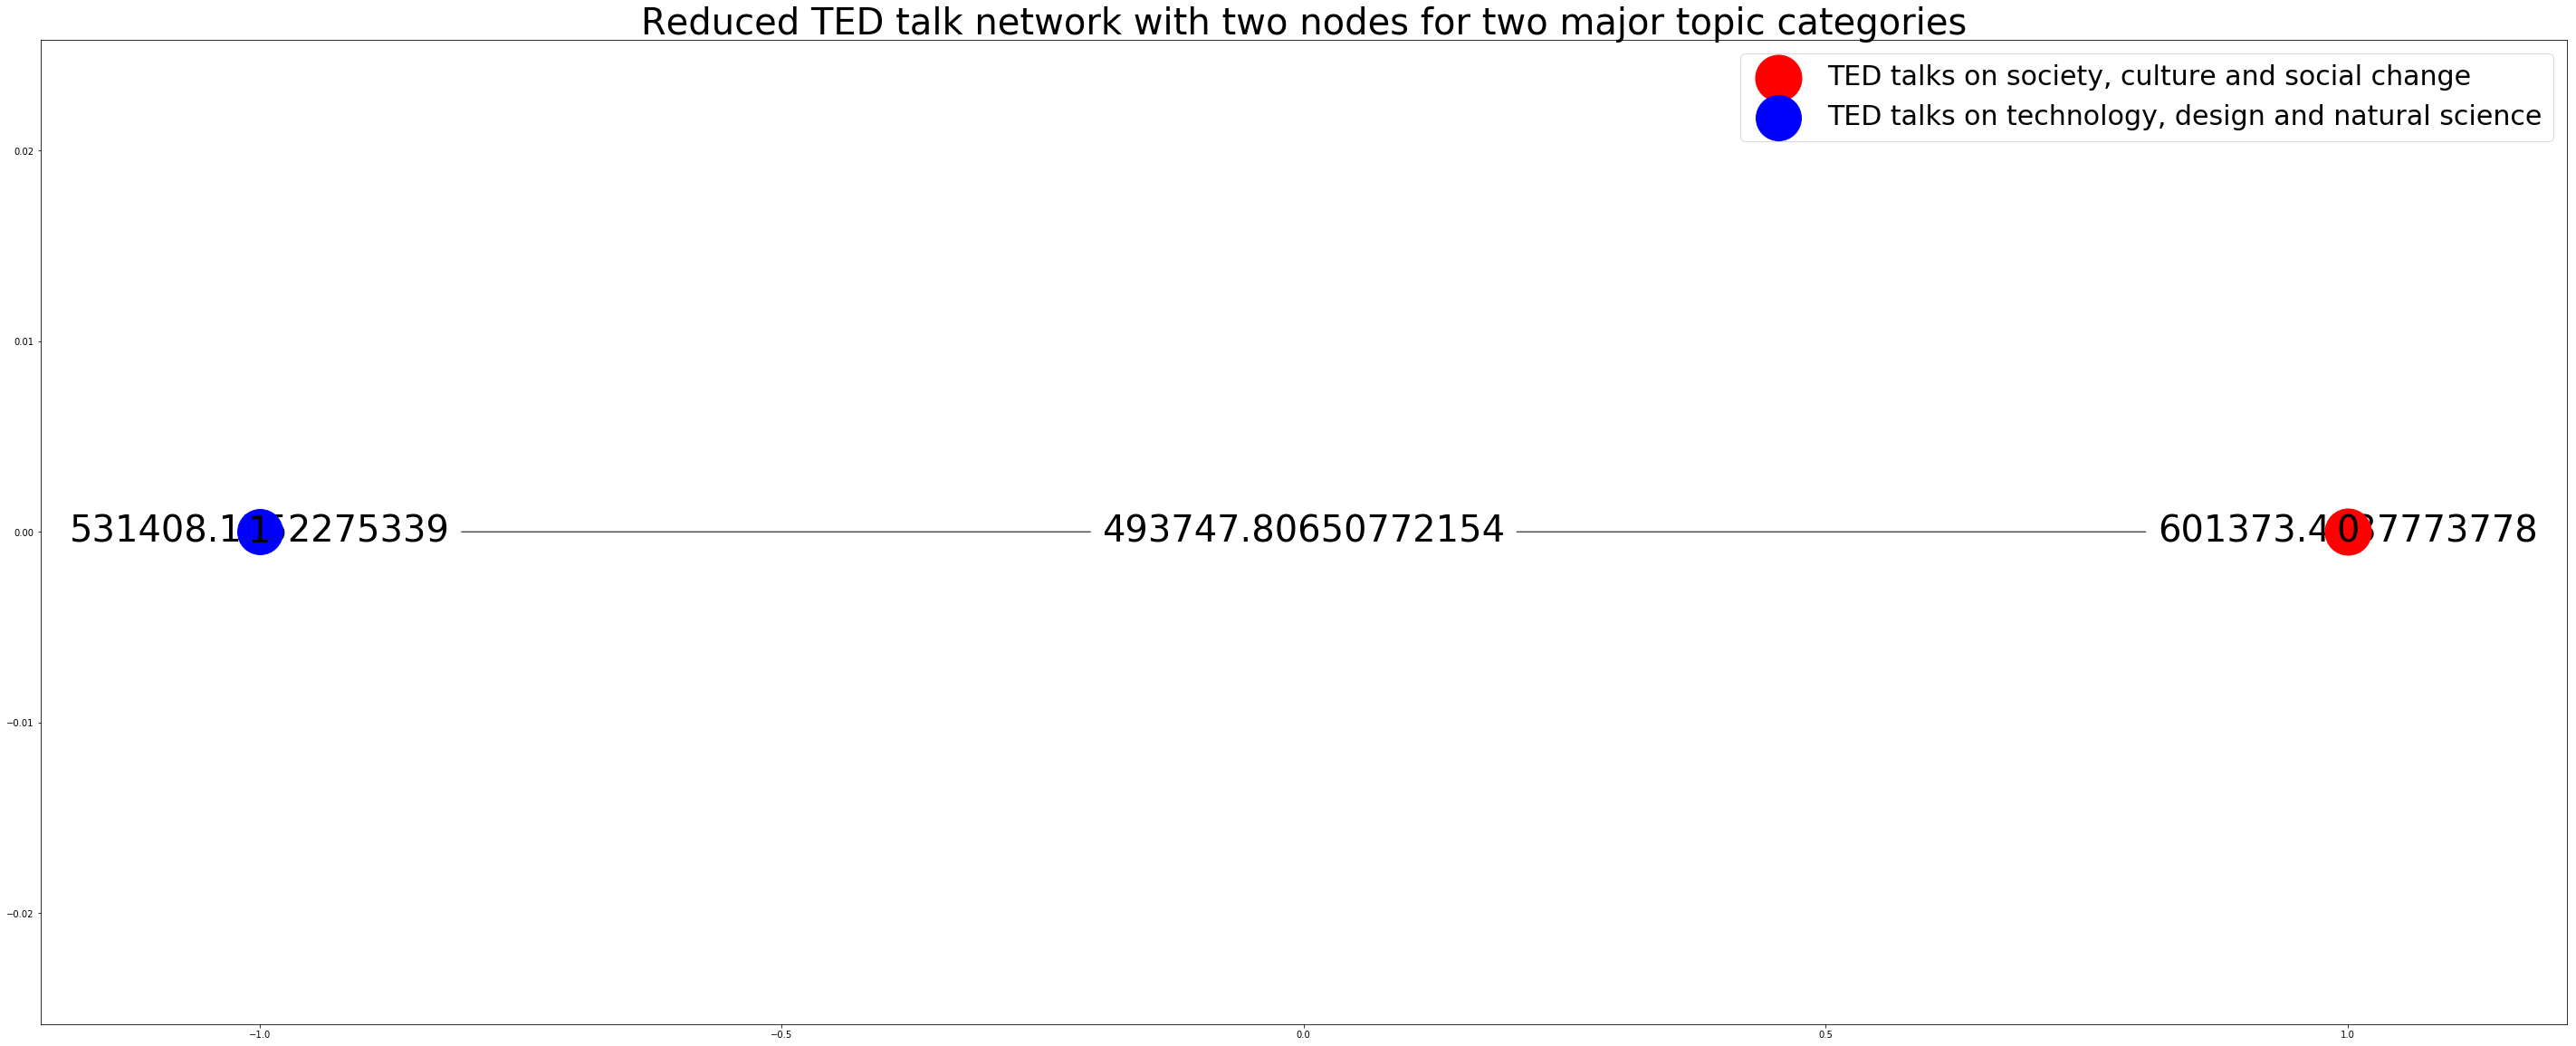

In [957]:
def draw_reduced_graph_2(g,year,size_tune):
    partition = community.best_partition(g)
    graph_reduced= community.induced_graph(partition, g)
    red_size = len([t[0] for t in partition.items() if t[1]==0])
    blue_size = len([t[0] for t in partition.items() if t[1]==1])
    
    plt.figure(figsize=(50,20))
    pos = nx.circular_layout(graph_reduced)
    nx.draw_networkx_nodes(graph_reduced,pos=pos,node_size = red_size*size_tune,nodelist=[0], node_color='red', label='TED talks on society, culture and social change')
    nx.draw_networkx_nodes(graph_reduced,pos=pos,node_size = blue_size*size_tune,nodelist=[1], node_color='blue', label='TED talks on technology, design and natural science')
    nx.draw_networkx_edges(graph_reduced,pos=pos)
    nx.draw_networkx_labels(graph_reduced,pos=pos,font_size=40)
    labels = nx.get_edge_attributes(graph_reduced,'weight')
    nx.draw_networkx_edge_labels(graph_reduced,pos,edge_labels=labels,font_size=40,label_pos=0.5)
    plt.legend(loc = 0, ncol = 1,prop={'size': 30})
    if year==-1:
        plt.title("Reduced TED talk network with two nodes for two major topic categories",size=40)
    else:
        plt.title("Reduced TED talk network in year "+str(year)+" with two nodes for each major topic category",size=40)
    plt.show()
    
draw_reduced_graph_2(g_2,-1,2)

The inter-node weight or the 'coupling' metric between the two categories is around 493748, while the intra-node weights or the 'cohesion' measurements for read node and blue node are about 601373 and 531408 respectively. So we can compute the similarity ratio for this reduced graph:
$$ratio = \frac{2*493748}{(601373+531408)}$$

In [958]:
print(compute_ratio(g_2))

0.8717440371254839


To confirm the interdisciplinarity trend of TED talks from year 2009 to 2017 using the similarity, we apply the same procedure to data from year 2009 to 2017: 1)first build the topic networks for each year and 2)reduce each network to 2 clusters corresponding to the two major categories, finally 3) compute the similarity ratios based on the reduced network for each and check the trend. 

In [963]:
# a list for collecting similarity ratios from year 2009 to 2017
ratios = []
years = list(range(2009,2018))

for year in years:
    g_year = build_network(ted_data,year,0)
    partition_year = community.best_partition(g_year)
    graph_reduced_year= community.induced_graph(partition_year, g_year)
    ratios.append(compute_ratio(g_year))



Now we check the similiarity ratios for 2 major categories from year 2009 to 2017.

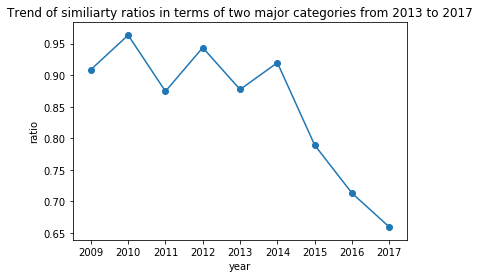

In [964]:
plt.plot(years, ratios)
plt.scatter(years,ratios)
plt.xlabel('year')
plt.ylabel('ratio')
plt.xticks(years)
plt.title("Trend of similiarty ratios in terms of two major categories from 2013 to 2017")
plt.show()

We can see the overall decreasing trend, which in some way confirms the general decreasing interdisciplinarity scores for TED talks from 2009 to 2017.

### Classification with four major categories

For now we classify all TED talks into two broad categories and find out the decreasing interdisciplinarity trend and the decreasing similarity trend in terms of the two categories. Next step we can further split each of the two broad categories into more sub-domains by increasing the number of major topic to 4, which increase the granularity of the model to faciliate the analysis of inter-category similarity.

In [747]:
num_topic = 4
coherences = []
ldas = []
passes = 10
for i in range(200):
    lda = LdaModel(corpus, id2word = dictionary,
                       num_topics = num_topic,
                       passes = passes)
    coherence_model_lda = CoherenceModel(model=lda, 
                                         texts=texts, 
                                         dictionary=dictionary, 
                                         coherence='c_v')
    coherences.append(coherence_model_lda.get_coherence()) 
    ldas.append(lda)


We choose the best lda model among 100 trials by picking the one with the highest model coherence score, and check keywords for each major topic: 

In [748]:
number_words = 20
lda = ldas[coherences.index(max(coherences))]
pp = pprint.PrettyPrinter(indent = 4)
pp.pprint(lda.print_topics(num_words = number_words))

[   (   0,
        '0.046*"culture" + 0.040*"entertainment" + 0.040*"art" + '
        '0.037*"communication" + 0.031*"personal growth" + 0.027*"creativity" '
        '+ 0.025*"humanity" + 0.024*"music" + 0.023*"performance" + '
        '0.023*"identity" + 0.020*"storytelling" + 0.020*"society" + '
        '0.017*"motivation" + 0.016*"children" + 0.016*"humor" + '
        '0.016*"language" + 0.015*"writing" + 0.015*"live music" + '
        '0.015*"family" + 0.013*"psychology"'),
    (   1,
        '0.084*"science" + 0.049*"health" + 0.033*"biology" + 0.032*"nature" + '
        '0.032*"medicine" + 0.026*"health care" + 0.024*"environment" + '
        '0.022*"medical research" + 0.022*"brain" + 0.021*"technology" + '
        '0.020*"innovation" + 0.019*"animals" + 0.018*"neuroscience" + '
        '0.017*"disease" + 0.017*"life" + 0.015*"illness" + 0.014*"future" + '
        '0.014*"biotech" + 0.014*"mind" + 0.013*"genetics"'),
    (   2,
        '0.053*"global issues" + 0.048*"social chan

From top 10 keywords in each major categories, we conclude and name the four major categories as follows:

+ 0 culture, art and personal growth
+ 1 natural science and medicine 
+ 2 global issues, society and social change
+ 3 techonolgy, design and innovation



In [749]:
#lda.save('lda4.gensim')
lda_4 = lda.load('lda4.gensim',mmap='r')


Next we apply the topic model to each talk's list of topics:

In [1039]:
num_topic = 4
topic_ids = ted_data['id'].tolist()
topic_scores_4 = [lda_4[ncorpus] for ncorpus in [dictionary.doc2bow(text) for text in texts]]
# some tweaks on score format
def add_zeros(topic_lst,n):
    topic_ids = set([t[0] for t in topic_lst])
    for i in range(n):
        if not i in topic_ids:
            topic_lst.insert(i, (i,0))
    return topic_lst
major_topics_4 = list(map(add_zeros,topic_scores_4,[num_topic]*len(topic_scores)))
ted_data['topics'] = major_topics_4

pp.pprint(major_topics_4[:3])
for i in range(3):
    print(ted_data['tags'].tolist()[i])

[[(0, 0.70451117), (1, 0.031345256), (2, 0.03179485), (3, 0.23234873)],
 [(0, 0.11063006), (1, 0.45155537), (2, 0.08142811), (3, 0.35638642)],
 [(0, 0.43914592), (1, 0.025071276), (2, 0.025113717), (3, 0.51066905)]]
['children', 'creativity', 'culture', 'dance', 'education', 'parenting', 'teaching']
['alternative energy', 'cars', 'climate change', 'culture', 'environment', 'global issues', 'science', 'sustainability', 'technology']
['computers', 'entertainment', 'interface design', 'media', 'music', 'performance', 'simplicity', 'software', 'technology']


For the first 3 talks' major topic classification, we see the first talk is almost focused on major topic 0 with evidence of 'children','culture','dance' and 'parenting' related to "culture, art and personal growth" combined with other keywords 'creativity','education' and  'teaching' related to major topic 3.

In contrast, the second talk is related on both major topic 1 and major topic 4 with several relevant keywords found in its list of keyword topics including 'alternative energy','climate change','environment','science' and 'sustainability' from the former, and 'technology' and 'cars' from the latter.

For the third talk, its focus on major talk 3 with weight of 0.51066536  can be confirmed by several number of keyword topics including 'computers', 'software' and 'technology' while the relateness to major talk 1 can be found from keywords 'entertainment', 'media', 'music', and 'performance'. 

Given all TED talks' major category scores, we also want to compute the interdisciplinarity score for each talk as defined before, this time in terms of 4 major categories:


$$inter\_score = pvalue（\chi^2(\sum_{i=1}^{4}\frac {(e_{i}-weight_{i})^2}{e_{i}},DOF=4-1)）$$


where $e_{i} = 1/4$

In [985]:
def compute_interscore(w,n):
    expected = [1/n]*n
    weights = [(t[1]) for t in w]
    return chisquare(weights,expected).pvalue

ted_data['inter_score_4'] = [compute_interscore(talk_weight,4) for talk_weight in major_topics]
ted_data['inter_score_4'].head(3)

0    0.750705
1    0.939900
2    0.844782
Name: inter_score_4, dtype: float64

Again We want to check the temporal trend of interdisciplinarity score in terms of 4 major categories.


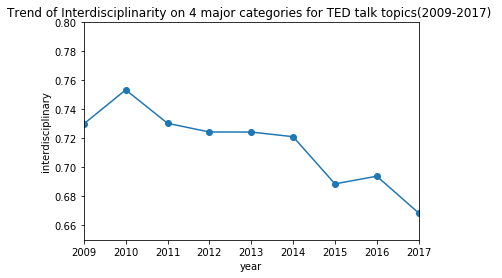

In [986]:
plt.plot(ted_data.groupby('year')['inter_score_4'].mean())
plt.scatter(range(2009,2018),ted_data.groupby('year')['inter_score_4'].mean()[-9:])
plt.xlabel('year')
plt.xlim([2009,2017])
plt.ylim([0.65,0.80])
plt.ylabel('interdisciplinary')
plt.title('Trend of Interdisciplinarity on 4 major categories for TED talk topics(2009-2017) ')
plt.show()


We can see the overall trend that the topic interdisciplinarity in terms of 4 major categories is decreasing, similar to the case when the number of major category = 2.

Next we model the topic similarity between TED talks using a network in terms of the major topic distribution, and this time we expect the find 4 clusters in the network.

In [891]:
def draw_network_4(g,data_period,threshold):
    # identify communities in network using Louvain method
    partition = community.best_partition(g)
    colors=['red','blue','green','orange']
    labels = ['TED talks on culture, art and personal growth',
              'TED talks on natural science and medicine',
              'TED talks on technology, design and innovation',
              'TED talks on global issues, society and social change'
             ]
    
    plt.figure(figsize=(30,30))
    pos = nx.spring_layout(g)
    for i in list(range(4)):
        nodes = [t[0] for t in partition.items() if t[1]==i]
        nx.draw_networkx_nodes(g,pos=pos,nodelist=nodes, node_color=colors[i], label=labels[i])
  
    nx.draw_networkx_edges(g,pos=pos)
    plt.legend(loc = 0, ncol = 1,prop={'size': 30})
    plt.title("TED talk network with 4 major topic categories when threshold = {:.1f}".format(threshold),size=40)
    plt.show()

In [904]:
#first build the network
g_4 = build_network(ted_data,-1,0)


In [988]:
partition_4 = community.best_partition(g_4)


In [989]:
list(partition_4.items())[:20]


[('0', 0),
 ('1', 1),
 ('2', 2),
 ('3', 3),
 ('4', 2),
 ('5', 0),
 ('6', 0),
 ('7', 2),
 ('8', 0),
 ('9', 0),
 ('10', 3),
 ('11', 0),
 ('12', 1),
 ('13', 2),
 ('14', 3),
 ('15', 0),
 ('16', 0),
 ('17', 2),
 ('18', 2),
 ('19', 2)]

In [990]:
print(major_topics[0])
print(major_topics[1])
print(major_topics[2])
print(major_topics[3])


[(0, 0.70459795), (1, 0.03134524), (2, 0.031794813), (3, 0.23226199)]
[(0, 0.11096019), (1, 0.4523825), (2, 0.08027461), (3, 0.3563827)]
[(0, 0.4391433), (1, 0.025071267), (2, 0.025113842), (3, 0.5106716)]
[(0, 0.027957607), (1, 0.030056298), (2, 0.65518916), (3, 0.28679696)]



+ 0 culture, art and personal growth
+ 1 natural science and medicine 
+ 2 global issues, society and social change
+ 3 techonolgy, design and innovation

Comparing the two varible partition and major_topics, we figure out the following mapping between partition numbers and the major categories:

+ partition number 0 --> TED talks on culture, art and personal growth
+ partition number 1 --> TED talks on natural science and medicine 
+ partition number 2 --> TED talks on techonolgy, design and innovation
+ partition number 3 --> TED talks on global issues, society and social change


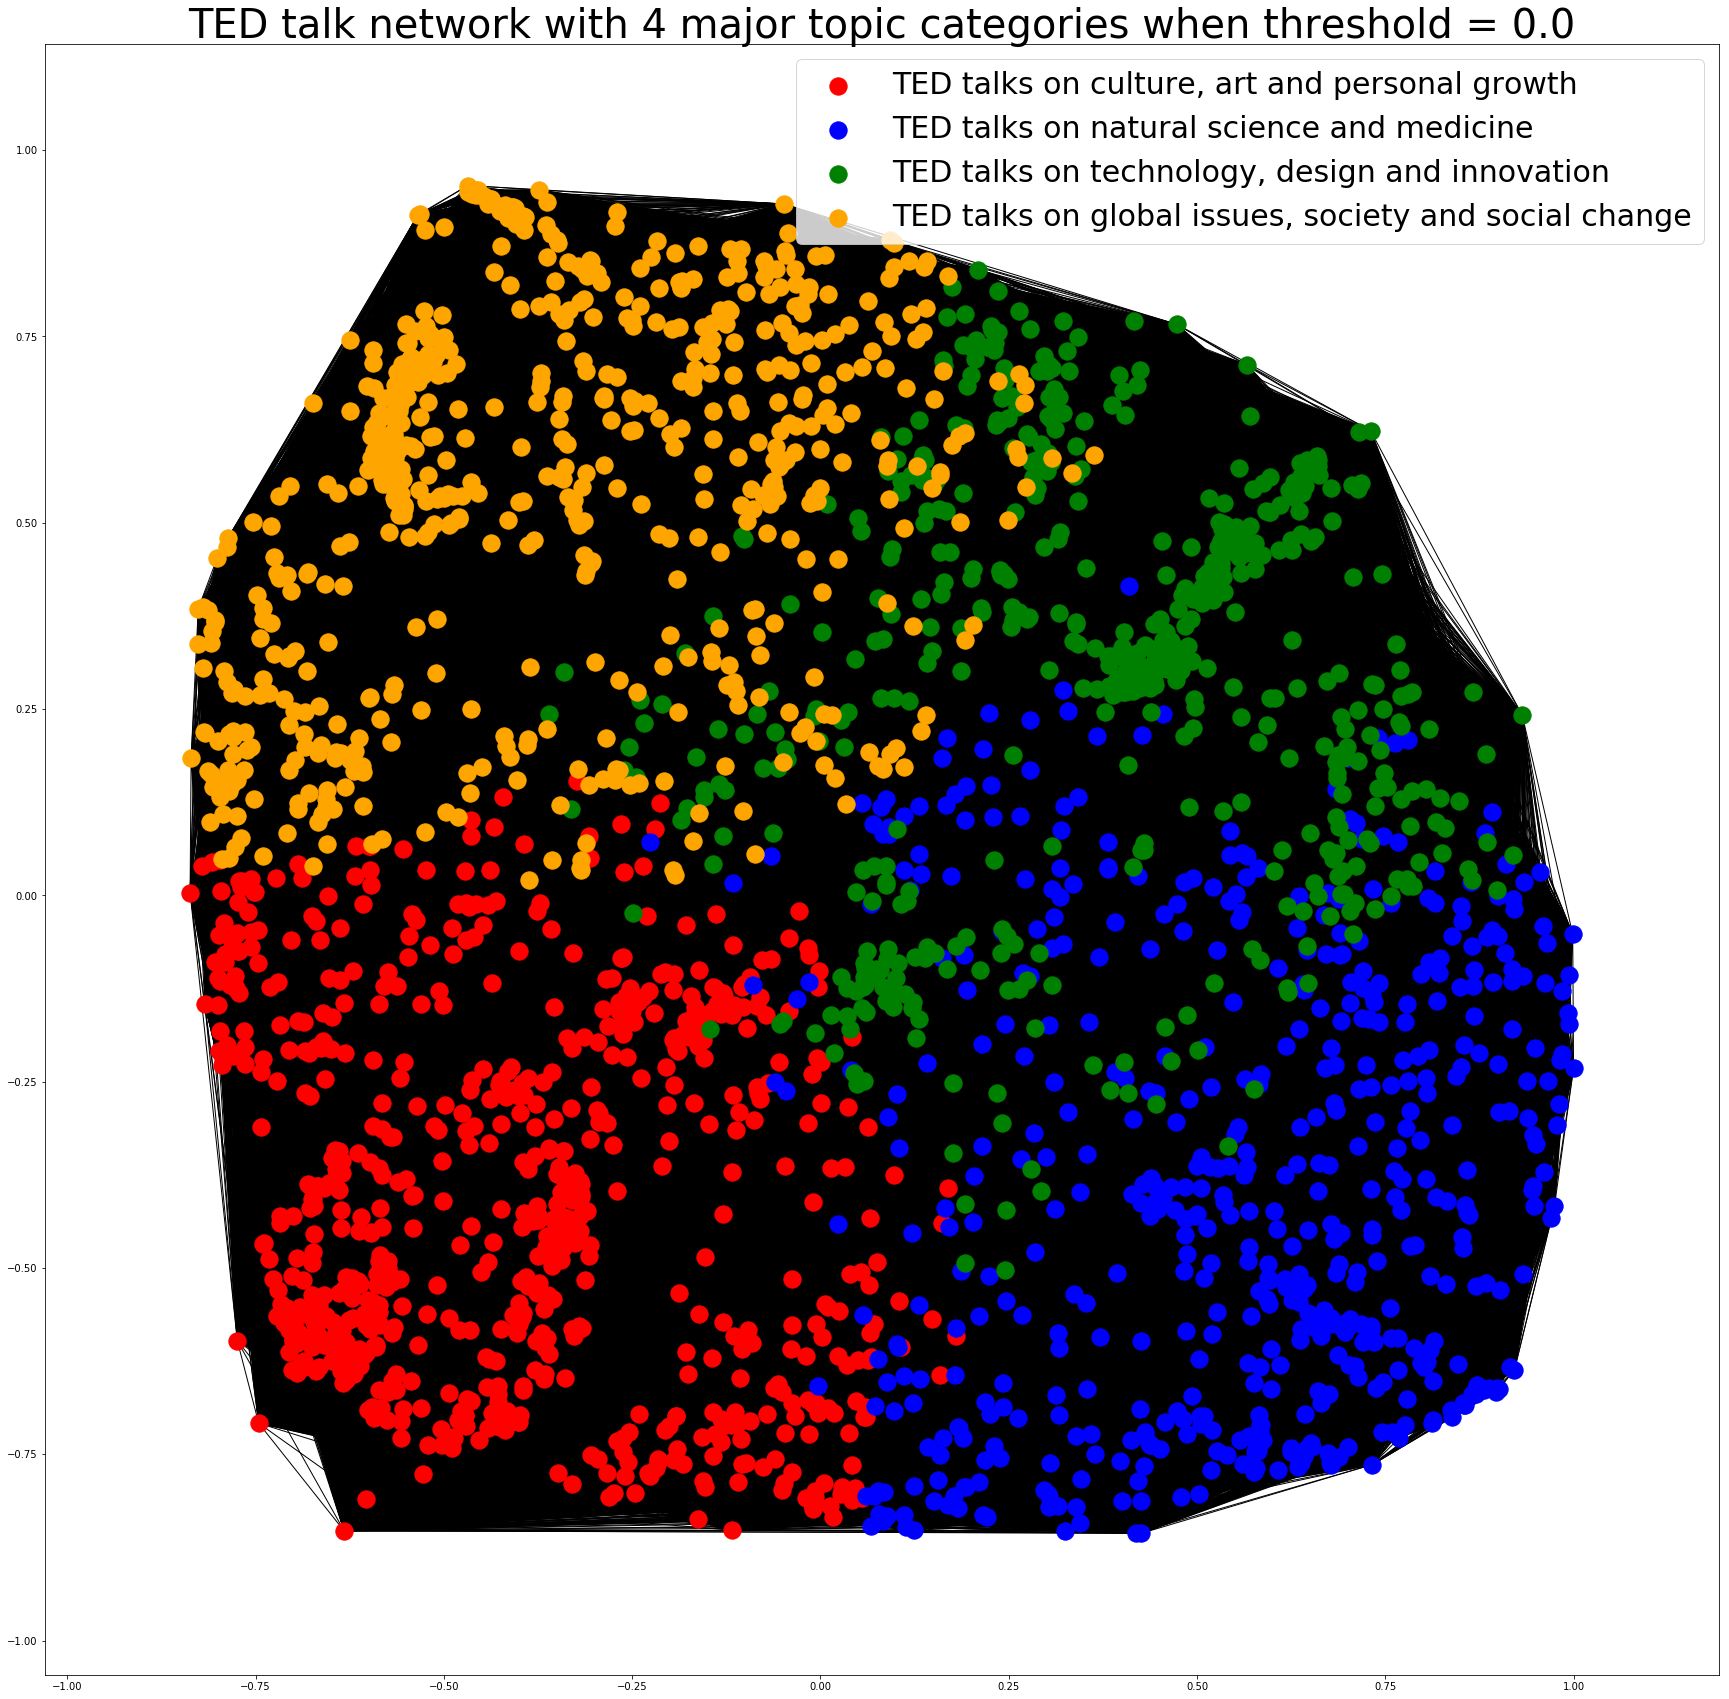

In [922]:
draw_network_4(g_4,ted_data,0)

Using the Louvain algorithm we find out four clusters in the network corresponding to the four major categories. But they are not quite clearly separated. In fact we can find overlapped area of orange and blue dots, for example, suggesting strong similarity between talks on 'global issues, society and social change' and talks on 'natural science and medicine'. To examine these overlapings, we reduce the network to one with only 4 nodes as we did before, and check the similarity ratio based on the reduced network. But before that, to take a look at a more clearly separated network, we increase the weight treshold to 0.4 and expect the connections between two clusters to be attenuated:

In [765]:
g_0_4 = build_network(ted_data,-1,0.4)


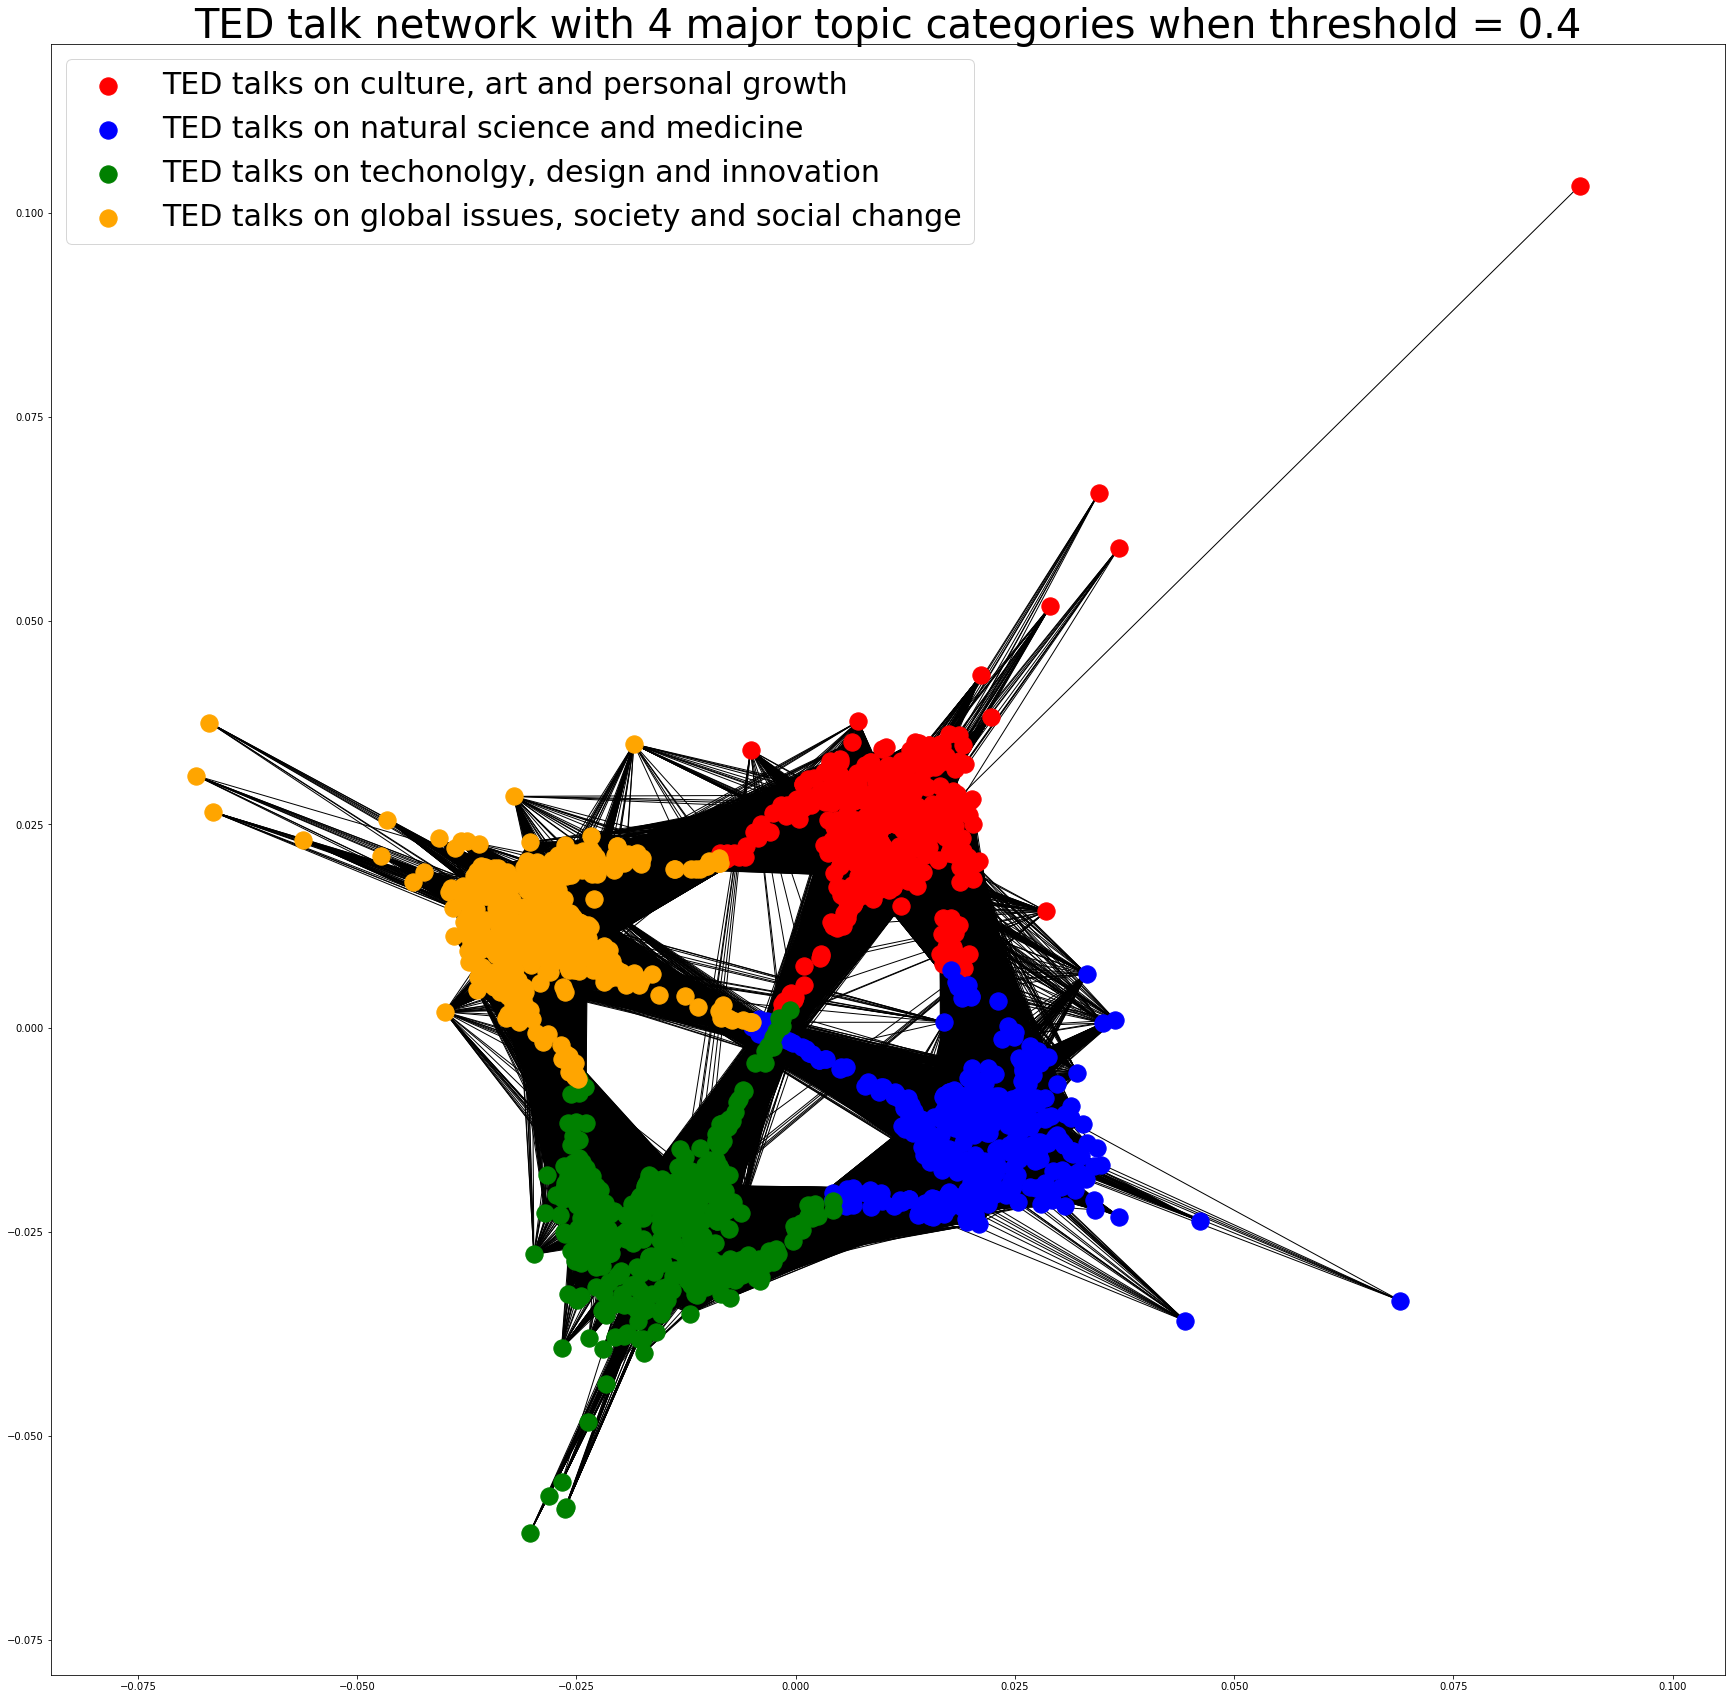

In [766]:
draw_network_4(g_0_4,ted_data,0.4)

Next back to the original network, we first find out the numbers of TED talks from each major category. 

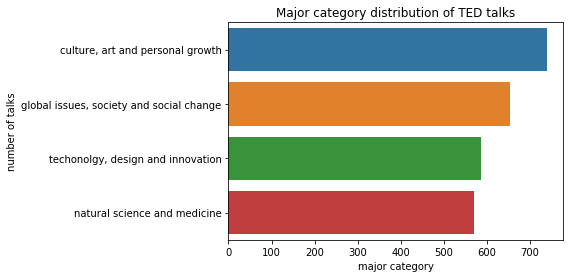

In [992]:
categories = list(partition_4.values())
ser = pd.Series(categories).value_counts().sort_index()
labels = ['culture, art and personal growth',
          'natural science and medicine',
            'techonolgy, design and innovation',
             'global issues, society and social change'
             ]
plt.xticks(rotation=0)
ser1 = pd.Series(ser.values,index=labels).sort_values(ascending=False)
sns.barplot(y=ser1.index,x=ser1.values).set_title("Major category distribution of TED talks")
plt.xlabel('major category')
plt.ylabel('number of talks')
plt.show()

To measure the strength of 'bond' between different major categories, we reduce the original network to one with 4 nodes for 4 major categories and compute the similarity ratio between nodes as we did before. 

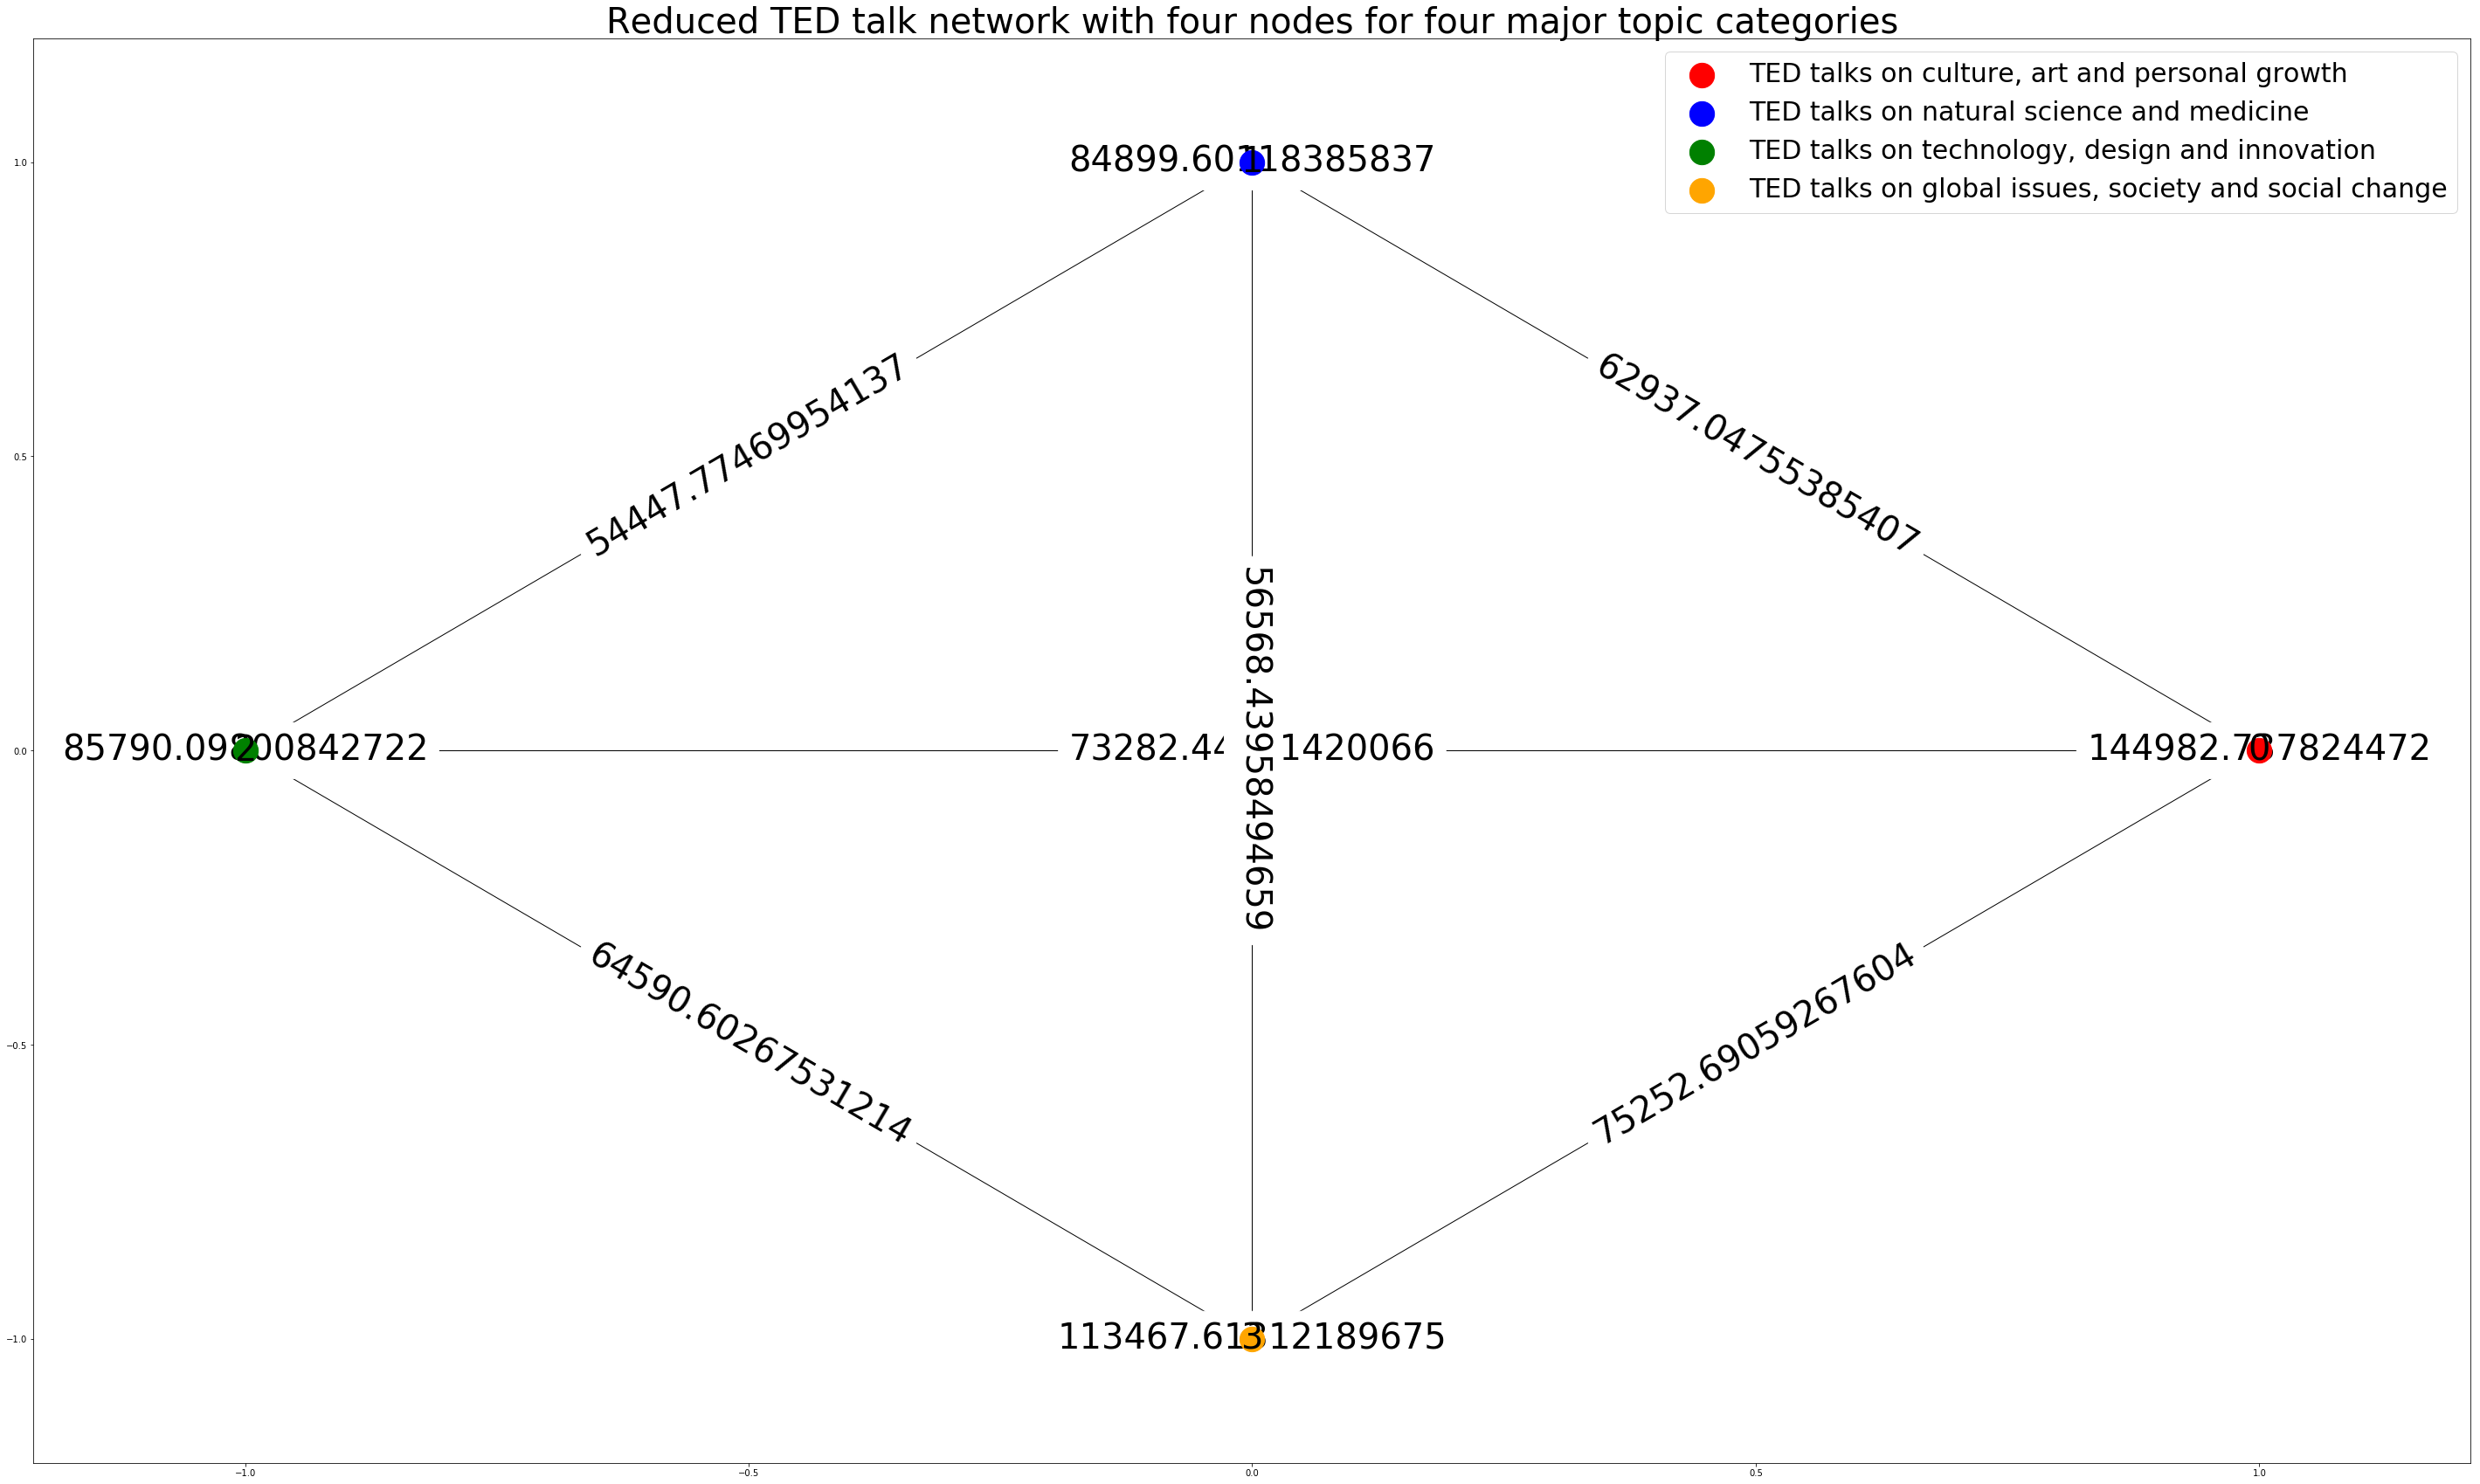

In [969]:
def draw_reduced_graph_4(g,year):
    partition = community.best_partition(g)
    graph_reduced= community.induced_graph(partition, g)
    plt.figure(figsize=(50,30))
    pos = nx.circular_layout(graph_reduced)
    colors=['red','blue','green','orange']
    labels = ['TED talks on culture, art and personal growth',
              'TED talks on natural science and medicine',
              'TED talks on technology, design and innovation',
              'TED talks on global issues, society and social change'
             ]
    for i in range(4):
        nx.draw_networkx_nodes(graph_reduced,pos=pos,nodelist=[i], node_color=colors[i],node_size = 800, label=labels[i])
    
    nx.draw_networkx_edges(graph_reduced,pos=pos)
    nx.draw_networkx_labels(graph_reduced,pos=pos,font_size=40)
    labels = nx.get_edge_attributes(graph_reduced,'weight')
    nx.draw_networkx_edge_labels(graph_reduced,pos,edge_labels=labels,font_size=40,label_pos=0.5)
    plt.legend(loc = 0, ncol = 1,prop={'size': 30})
    if year==-1:
        plt.title("Reduced TED talk network with four nodes for four major topic categories",size=40)
    else:
        plt.title("Reduced TED talk network in year "+str(year)+" with four nodes for each major topic category",size=40)
    plt.show()
    
draw_reduced_graph_4(g_4,-1)

In [993]:
def compute_ratio_4(graph_reduced,i,j):
    # compare the 'cohesion' for intra-cluster with the 'coupling' for inter-cluster 
    within_cluster = graph_reduced[i][i]['weight']+graph_reduced[j][j]['weight']
    between_cluster = graph_reduced[i][j]['weight']
    return 2*between_cluster/within_cluster


Using the compute_ratio_4 function, we compute the similarity ratios for each pair of major categories, totally 6 pairs. 

In [994]:
ratios={}
graph_reduced_4= community.induced_graph(partition_4, g_4)
for i in range(4):
    for j in range(i+1,4):
        ratios[(i,j)] = compute_ratio_4(graph_reduced_4,i,j)

In [995]:
ratios

{(0, 1): 0.5478202531699162,
 (0, 2): 0.6354415587086529,
 (0, 3): 0.5832775977172132,
 (1, 2): 0.6379737612426721,
 (1, 3): 0.5702128045929261,
 (2, 3): 0.6481739649877701}

In [996]:
sorted(ratios.items(),key=lambda x:x[1],reverse=True)

[((2, 3), 0.6481739649877701),
 ((1, 2), 0.6379737612426721),
 ((0, 2), 0.6354415587086529),
 ((0, 3), 0.5832775977172132),
 ((1, 3), 0.5702128045929261),
 ((0, 1), 0.5478202531699162)]

Sorting the ratios from high score to low, we can see the "closest" pair of major categories are 'global issues, society and social change' and 'technology, design and innovation'. 

But how about the trend? Next we apply the same procedure to ted talks for each year from 2009 to 2016: 1)first build the topic networks for each period and 2)reduce each network to 4 clusters corresponding to the six major categories, finally 3) compute the similarity ratios based on the reduced network for each and check the trend. 

In [789]:
ted = ted_data.set_index('id')

In [1085]:
ratios_4 = []
freq_4 = []
for year in range(2009,2017):
    g_year = build_network(ted_data,year,0)
    partition_year = community.best_partition(g_year)
    freq_4.append(dict(pd.Series(list(partition_year.values())).value_counts()))
    # print out a few talks' major categoris and partition number to
    # find out the mapping between them
    major_topics = ted[ted['year']==year]['topics']
    pp.pprint("Year "+ str(year))
    
    for i in range(20):
        t = list(partition_year.items())[i]
        pp.pprint(t)
        pp.pprint(major_topics[t[0]])
    # compute the similarity ratios for every pair of major categories 
    # from year 2009 to 2016
    graph_reduced_year = community.induced_graph(partition_year, g_year)
    ratios={}
    for i in range(4):
        for j in range(i+1,4):
            ratios[(i,j)] = compute_ratio_4(graph_reduced_year,i,j)
    ratios_4.append(ratios)


 

'Year 2009'
('329', 0)
[(0, 0.036057096), (1, 0.20070378), (2, 0.0370349), (3, 0.7262042)]
('330', 1)
[(0, 0.71694183), (1, 0.036169913), (2, 0.044372343), (3, 0.20251589)]
('331', 2)
[(0, 0.06257065), (1, 0.07421245), (2, 0.798862), (3, 0.0643549)]
('332', 0)
[(0, 0.04107467), (1, 0.03573913), (2, 0.0358533), (3, 0.8873329)]
('333', 3)
[(0, 0.18331377), (1, 0.5146456), (2, 0.03145966), (3, 0.27058098)]
('334', 2)
[(0, 0.031380057), (1, 0.13097657), (2, 0.80616164), (3, 0.03148174)]
('403', 1)
[(0, 0.52861047), (1, 0.27315786), (2, 0.022976808), (3, 0.17525493)]
('407', 1)
[(0, 0.5064056), (1, 0.2804027), (2, 0.028595429), (3, 0.18459634)]
('412', 1)
[(0, 0.4204899), (1, 0.08475444), (2, 0.08515936), (3, 0.40959632)]
('413', 1)
[(0, 0.90408117), (1, 0.031798296), (2, 0.03175277), (3, 0.032367773)]
('415', 1)
[(0, 0.9051952), (1, 0.03128984), (2, 0.03210555), (3, 0.03140948)]
('418', 0)
[(0, 0.04281361), (1, 0.04207363), (2, 0.042162716), (3, 0.87295)]
('420', 1)
[(0, 0.6259675), (1, 0.

('1702', 0)
[(0, 0.64146376), (1, 0.036742356), (2, 0.28530508), (3, 0.036488812)]
('1703', 1)
[(0, 0.063660875), (1, 0.062690005), (2, 0.80872655), (3, 0.064922586)]
('1704', 1)
[(0, 0.044382364), (1, 0.041743387), (2, 0.8703364), (3, 0.043537825)]
('1705', 2)
[(0, 0.050451353), (1, 0.050012123), (2, 0.050556116), (3, 0.84898037)]
('1706', 1)
[(0, 0.0453245), (1, 0.041781493), (2, 0.868711), (3, 0.044183042)]
('1707', 2)
[(0, 0.050165307), (1, 0.050500743), (2, 0.24947882), (3, 0.64985514)]
('1708', 3)
[(0, 0.022794202), (1, 0.9317265), (2, 0.022738025), (3, 0.022741275)]
('1709', 2)
[(0, 0.06359713), (1, 0.06279273), (2, 0.0655625), (3, 0.8080476)]
('1711', 1)
[(0, 0.02633921), (1, 0.025307557), (2, 0.92289543), (3, 0.025457826)]
('1712', 0)
[(0, 0.56254596), (1, 0.31244603), (2, 0.062503606), (3, 0.06250437)]
('1714', 1)
[(0, 0.05071288), (1, 0.050040595), (2, 0.8479764), (3, 0.051270183)]
('1715', 2)
[(0, 0.050684027), (1, 0.05117067), (2, 0.051843405), (3, 0.84630185)]
('1716', 1)

From the above results we derive the following mapping 

year 2009:
+ partition number 0 --> major category 3
+ partition number 1 --> major category 0
+ partition number 2 --> major category 2
+ partition number 3 --> major category 1 

year 2010:
+ partition number 0 --> major category 1
+ partition number 1 --> major category 3
+ partition number 2 --> major category 2
+ partition number 3 --> major category 0

year 2011:
+ partition number 0 --> major category 3
+ partition number 1 --> major category 0
+ partition number 2 --> major category 1
+ partition number 3 --> major category 2 

year 2012:
+ partition number 0 --> major category 3
+ partition number 1 --> major category 1
+ partition number 2 --> major category 0
+ partition number 3 --> major category 2 

year 2013:
+ partition number 0 --> major category 2
+ partition number 1 --> major category 3
+ partition number 2 --> major category 1
+ partition number 3 --> major category 0 

year 2014:
+ partition number 0 --> major category 0
+ partition number 1 --> major category 2
+ partition number 2 --> major category 3
+ partition number 3 --> major category 1 

year 2015:
+ partition number 0 --> major category 0
+ partition number 1 --> major category 2
+ partition number 2 --> major category 3
+ partition number 3 --> major category 1 

year 2016:
+ partition number 0 --> major category 3
+ partition number 1 --> major category 0
+ partition number 2 --> major category 1
+ partition number 3 --> major category 2 

We can visualize both the number talks for each major cateogry over years and the similarity ratios for every pair of major categories over years.from the results. But we know the coding paritition number pairs in different years have different meanings, so first we need to translate them into major category pairs based on the mapping which we can construct the mapping using a list of lists in order from year 2009 to 2016 that we figured out before.

In [886]:
ratios_uniform={}
freq_uniform = {}
mapping = [[3,0,2,1],[1,3,2,0],
           [3,0,1,2],[3,1,0,2],
           [2,3,1,0],[0,2,3,1],
           [0,2,3,1],[3,0,1,2]]
for i in range(len(mapping)):
    for pnumber in freq_4[i]:
        mnumber = mapping[i][pnumber]
        if mnumber not in freq_uniform:
            freq_uniform[mnumber] = []
        freq_uniform[mnumber].append(freq_4[i][pnumber])
    for t in ratios_4[i]:
        new_t = (mapping[i][t[0]],mapping[i][t[1]])
        new_t_1 = (mapping[i][t[1]],mapping[i][t[0]])
        if new_t in ratios_uniform:
            ratios_uniform[new_t].append(ratios_4[i][t])
        elif new_t_1 in ratios_uniform:
            ratios_uniform[new_t_1].append(ratios_4[i][t])
        else:
            ratios_uniform[new_t]=[ratios_4[i][t]]


{0: [72, 67, 88, 76, 73, 62, 65, 59],
 1: [55, 69, 67, 62, 60, 57, 55, 51],
 2: [43, 68, 63, 53, 66, 70, 77, 89],
 3: [62, 63, 52, 76, 71, 48, 42, 47]}
{(0, 1): [0.601667271789929,
          0.6617937726282004,
          0.6037338923490306,
          0.5735009902965158,
          0.5541264738684414,
          0.5821435014360867,
          0.5183162297024883,
          0.4504135499669556],
 (0, 2): [0.5681538247918676,
          0.7044519166388931,
          0.6141874070352232,
          0.5610883036723636,
          0.5457416008466353,
          0.6140262257666015,
          0.4484893431299225,
          0.534634928051554],
 (2, 1): [0.6652338149980044,
          0.7307263877371699,
          0.48339195287135783,
          0.5365448003870698,
          0.5056951057390041,
          0.5441420151190788,
          0.47057916475079015,
          0.5183706826084523],
 (3, 0): [0.6078317577655764,
          0.8326447784350396,
          0.6021335177514938,
          0.6640997639911119,
     

Next we visualize the trends for six pairs of major categories:


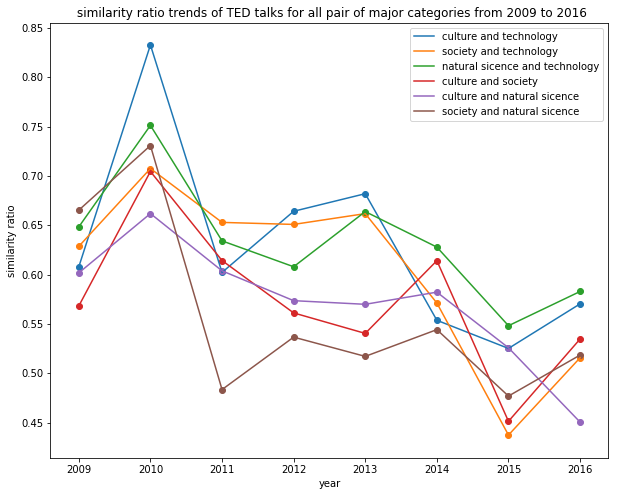

In [875]:
labels1 = {(0, 1):'culture and natural sicence',
         (0, 2):'culture and society',
         (2, 1):'society and natural sicence',
         (3, 0):'culture and technology',
         (3, 1):'natural sicence and technology',
         (3, 2):'society and technology'}

plt.figure(figsize=(10,8))
for pair in ratios_uniform:
    plt.plot(x,ratios_uniform[pair],label=labels1[pair])
    plt.scatter(x,ratios_uniform[pair])

plt.title(" similarity ratio trends of TED talks for all pair of major categories from 2009 to 2016")
plt.xlabel('year')
plt.ylabel('similarity ratio')
plt.legend(loc = 1)
plt.show()

We can observe the general downslopes for all six pairs of major categories over years with two sharp declines during period (2010,2011) and period (2014,2015). From 2015 to 2016, bonds between all pairs except the pair 'culture and natural sicence' were strengthened. Among all pairs, two pairs of major categories had relatively strong bonds compared with other pairs over years: 'natural science and technology' and 'culture and technology' with the weakest bond 'society and natural sicence' from 2011 to 2014.     

### Classification with ten major categories

Now we increase the number of major categories to 10 which we found earlier is the global optimal and try another approach to interdisciplinarity analysis. We first choose a relatively large number of major categories and build one network for each year based on similarity between talk distributions on major categories, and then use Louvain algorithm to detect the clusters in each network as before to examine which major categories more often appear in one cluster and how the major category members in each cluster change in different years. Based on how many times every pair of major categories falls into one cluster over years, we build a new network with nodes of major category and edges weighted by number of times sharing one cluster, and then examine the relationship between some metrics of node centrality in the network and the average number of comments for each major category. 


First we check the number of TED talks from year 2009 to 2016 to make sure data for each year is big enough:

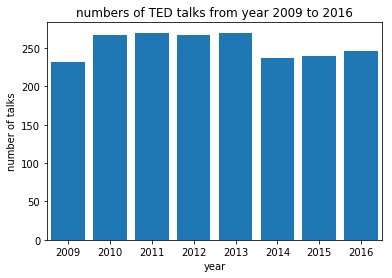

In [1030]:
data = ted_data.groupby('year')['id'].count()

plt.bar(x=data.index.tolist(),height=data.values)
plt.title('numbers of TED talks from year 2009 to 2016')
plt.xlim([2008.5,2016.5])
plt.xlabel('year')
plt.ylabel('number of talks')
plt.show()

We see the number of talks in each year is above 200. Next we apply the LDA top modeling to all TED talks, choosing 10 major catetogories.

In [1034]:
num_topic = 10
coherences = []
ldas = []
passes = 10
for i in range(200):
    lda = LdaModel(corpus, id2word = dictionary,
                       num_topics = num_topic,
                       passes = passes)
    coherence_model_lda = CoherenceModel(model=lda, 
                                         texts=texts, 
                                         dictionary=dictionary, 
                                         coherence='c_v')
    coherences.append(coherence_model_lda.get_coherence()) 
    ldas.append(lda)

number_words = 15  
lda = ldas[coherences.index(max(coherences))]
pp.pprint(lda.print_topics(num_words = number_words))

[(0,
  '0.085*"science" + 0.074*"health" + 0.065*"medicine" + 0.049*"health care" + '
  '0.048*"biology" + 0.045*"medical research" + 0.037*"technology" + '
  '0.035*"disease" + 0.033*"innovation" + 0.030*"illness"'),
 (1,
  '0.051*"brain" + 0.049*"personal growth" + 0.045*"humanity" + '
  '0.045*"children" + 0.038*"communication" + 0.038*"society" + 0.033*"mind" + '
  '0.030*"psychology" + 0.028*"parenting" + 0.028*"mental health"'),
 (2,
  '0.104*"design" + 0.103*"technology" + 0.049*"innovation" + '
  '0.045*"invention" + 0.037*"future" + 0.036*"computers" + '
  '0.032*"engineering" + 0.027*"product design" + 0.026*"creativity" + '
  '0.023*"cities"'),
 (3,
  '0.066*"communication" + 0.060*"society" + 0.044*"social change" + '
  '0.039*"africa" + 0.035*"community" + 0.035*"global issues" + '
  '0.030*"activism" + 0.029*"collaboration" + 0.029*"data" + 0.029*"humanity"'),
 (4,
  '0.103*"business" + 0.061*"economics" + 0.055*"society" + 0.048*"policy" + '
  '0.046*"work" + 0.040*"soci

From the keywords for each major category, we can summarize each major category as:
+ 0 health science and medicine
+ 1 mental health and personal growth
+ 2 design and technology
+ 3 communication and society
+ 4 business and economics
+ 5 environment and nature
+ 6 gender and culture
+ 7 space exploration and astronomy 
+ 8 global issues and politics
+ 9 entertainment and art

In [1041]:
#lda.save('lda10.gensim')
lda_10 = lda.load('lda10.gensim',mmap='r')

In [1097]:
ted = ted_data.set_index('id')

Next we compute category distributions for each TED talk:

In [1098]:
num_topic = 10
topic_ids = ted.index.tolist()
topic_scores_10 = [lda_10[ncorpus] for ncorpus in [dictionary.doc2bow(text) for text in texts]]
# some tweaks on score format
def add_zeros(topic_lst,n):
    topic_ids = set([t[0] for t in topic_lst])
    for i in range(n):
        if not i in topic_ids:
            topic_lst.insert(i, (i,0))
    return topic_lst
major_topics_10 = list(map(add_zeros,topic_scores_10,[num_topic]*len(topic_scores)))
ted['topics_10'] = major_topics_10

pp.pprint(major_topics_10[:3])
for i in range(3):
    print(ted['tags'].tolist()[i])

[[(0, 0.012500204),
  (1, 0.4996),
  (2, 0.012501628),
  (3, 0.012501003),
  (4, 0.01250204),
  (5, 0.012500264),
  (6, 0.012501431),
  (7, 0.012500852),
  (8, 0.012500349),
  (9, 0.40039223)],
 [(0, 0.010001647),
  (1, 0.010001692),
  (2, 0.21720739),
  (3, 0.010003158),
  (4, 0.010002738),
  (5, 0.6255971),
  (6, 0.08717563),
  (7, 0.010001679),
  (8, 0.010003119),
  (9, 0.010005783)],
 [(0, 0.010000848),
  (1, 0.010000374),
  (2, 0.50358856),
  (3, 0.1884561),
  (4, 0.010000415),
  (5, 0.010000359),
  (6, 0.01000036),
  (7, 0.010000836),
  (8, 0.010000555),
  (9, 0.2379516)]]
['children', 'creativity', 'culture', 'dance', 'education', 'parenting', 'teaching']
['alternative energy', 'cars', 'climate change', 'culture', 'environment', 'global issues', 'science', 'sustainability', 'technology']
['computers', 'entertainment', 'interface design', 'media', 'music', 'performance', 'simplicity', 'software', 'technology']


Again we can see the category distribution for the first three TED talks can be confirmed by their lists of keyword topics. For the first talk, its category distribution indicates an almost equal weights on major category 1 and 9, and the second talk are more relevant to major category 9 with than to major category 2, while the third talk is more focused on major category 2 with non-trivial relevances on category 3 and 9.

Using computed category distributions for all TED talks, we build networks of TED talks for each year in terms of similarity between talk distributions on 10 major categories as before.

In [1258]:
def build_network_10(ted_data,year,threshold):
    data_period = ted_data if year==-1 else ted_data[ted_data['year']==year]
    length = len(data_period)
    talk_ids = data_period.index.tolist()
    edge_list=[]
    for i in range(length):
        for j in range(i+1,length):
            weight = dot_product(data_period['topics_10'].tolist()[i],data_period['topics_10'].tolist()[j])
            if weight > threshold:
                edge_list.append((str(data_period.index.tolist()[i]),str(data_period.index.tolist()[j]),weight))
    g = nx.Graph()
    g.add_nodes_from(list(map(str,talk_ids)))
    g.add_weighted_edges_from(edge_list)
    return g

sizes = []
partitions_10 = []
for year in range(2009,2017):
    g_year_10 = build_network_10(ted,year,0)
    partition_year_10 = community.best_partition(g_year_10)
    partitions_10.append(partition_year_10)
    sizes.append(len(pd.Series(partition_year_10).value_counts()))

list(zip(list(range(2009,2017)),sizes))

[(2009, 5),
 (2010, 7),
 (2011, 7),
 (2012, 6),
 (2013, 5),
 (2014, 7),
 (2015, 6),
 (2016, 6)]

So we can see the number of clusters do change in different years. Next we want to examine how each cluster in each network corresponds to one major category or combination of several categories and how members of each cluster change in different years. 

In [1101]:
# add a column indicating the major category based on the 
# category distribution for each TED talk
ted['category'] = ted['topics_10'].apply(lambda x: sorted(x,key=lambda t:t[1],reverse=True)[0][0])

In [1134]:
clusters = []
for year in range(2009,2017):
    category_year = ted[ted['year']==year]['category']
    cluster_year = {}
    ser1 = pd.Series(partitions_10[year-2009],name='pnumber')
    df_year = pd.concat([category_year,ser1],axis=1)
    for category in list(range(10)):
        ser2 = df_year[df_year['category']==category]['pnumber'].value_counts()
        pnumber = ser2[ser2.values==max(ser2.values)].index[0]
        if pnumber not in cluster_year:
            cluster_year[pnumber] = []
        cluster_year[pnumber].append(category)
    clusters.append(cluster_year)
    pp.pprint('year '+str(year))
    pp.pprint(cluster_year)

'year 2009'
{0: [2], 1: [1, 3, 4, 6, 8], 2: [5], 3: [0, 7], 4: [9]}
'year 2010'
{0: [0, 7], 1: [2], 2: [1, 4, 6], 3: [8], 4: [9], 5: [5], 6: [3]}
'year 2011'
{0: [2], 1: [9], 2: [1], 3: [5], 4: [3], 5: [4, 6, 8], 6: [0, 7]}
'year 2012'
{0: [3], 1: [1], 2: [9], 3: [0, 5, 7], 4: [2], 5: [4, 6, 8]}
'year 2013'
{0: [6, 7, 9], 1: [3, 4, 8], 2: [2], 3: [0, 5], 4: [1]}
'year 2014'
{0: [1], 1: [3, 4, 6], 2: [2], 3: [5, 7], 4: [8], 5: [9], 6: [0]}
'year 2015'
{0: [3, 4, 8], 1: [1], 2: [2], 3: [6, 9], 4: [0, 7], 5: [5]}
'year 2016'
{0: [2, 5, 7], 1: [3, 6, 8, 9], 2: [0], 3: [1], 4: [4]}


Major category codebook for reference:
+ 0 health science and medicine
+ 1 mental health and personal growth
+ 2 design and technology
+ 3 communication and society
+ 4 business and economics
+ 5 environment and nature
+ 6 gender and culture
+ 7 space exploration and astronomy 
+ 8 global issues and politics
+ 9 entertainment and art

We can see some interesting relationships between different major categories from the above result: 
1. Major category 0, 5 and 7 were close to each other over years, which is no surprise since they are all related to the natural science.
2. Major category 3, 4, 6, 8 were close to each other over years, which is also intuitive as they are all related to the social world. 
3. Major category 1 was related to category 4 and 6 in early years but became more "independent" later on. 
4. Major category 2 had its own unique share in TED talks and touched other categories less frequently until year 2016 when it connected with category 5 and 7, two other disciplines from the natural science, for the first time.
5. For major category 9, it was more 'independent' in early years than later years when it appeared more often with category 6 and once with category 7 from the natural world and once with category 3 and 8 from the social world.

To visualize these features, we draw a network with nodes of major categories, and an edge between two nodes is weighted by how many times these two major categories falls into one cluster over years.  

In [1218]:
edges={}
for i in range(0,10):
    for j in range(i+1, 10):
        for cluster_year in clusters:
            for c in list(cluster_year.values()):
                if i in c and j in c:
                    if (i, j) not in edges:
                        edges[(i,j)] = 0
                    edges[(i,j)]+=1
edges_category_10 = [(edge[0],edge[1],edges[edge]) for edge in edges]
# build a weighted graph for 10 major categories
g_cateogry_10 = nx.Graph()
g_cateogry_10.add_nodes_from(list(range(10)))
g_cateogry_10.add_weighted_edges_from(edges_category_10)

partition_category_10 = community.best_partition(g_cateogry_10)
pp.pprint(pd.Series(partition_category_10).value_counts())

1    6
0    4
dtype: int64


In [1219]:
partition_category_10

{0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 0, 8: 1, 9: 1}

In [1242]:
labels = {
0:"0 health science and medicine",
1:"1 mental health and personal growth",
2:"2 design and technology",
3:"3 communication and society",
4:"4 business and economics",
5:"5 environment and nature",
6:"6 gender and culture",
7:"7 space exploration and astronomy",
8:"8 global issues and politics",
9:"9 entertainment and art"
}

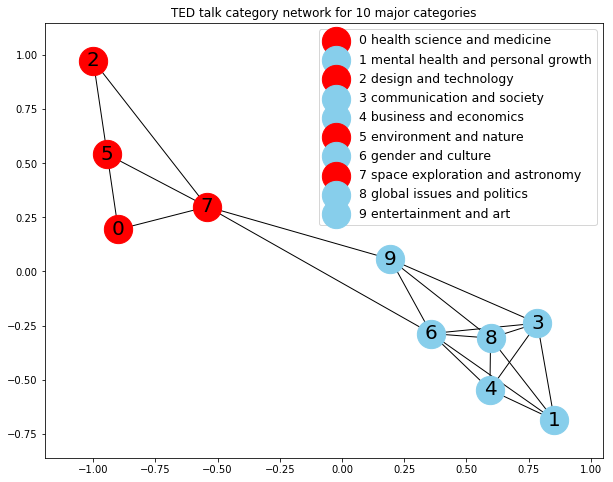

In [1254]:
plt.figure(figsize=(10,8))
pos = nx.spring_layout(g_cateogry_10)
color=['red','skyblue']
colors = {t[0]:color[t[1]] for t in partition_category_10.items()} 
for i in range(10):
    nx.draw_networkx_nodes(g_cateogry_10,pos=pos,nodelist=[i], node_color=colors[i],label=labels[i],node_size = 800)
    
nx.draw_networkx_edges(g_cateogry_10,pos=pos)
nx.draw_networkx_labels(g_cateogry_10,pos=pos,font_size=20)
plt.title("TED talk category network for 10 major categories")
plt.legend(loc = 0, ncol = 1,prop={'size': 12.5})
plt.show()

We can see that the network for 10 major categories contains 2 clusters as we expect. Major category 0, 2, 5 and 7 are more related to the natural science while major category 1, 3, 4, 6, 8 and 9 are more close to the social world.

Given the network of 10 major categories, next we wonder if there is any relationship between the average popularity of TED talks from one major category and some metric measuring the position or 'power' of this category in the network. The first metric we choose is the eigenvector centrality by which each node's centrality depends on its neighbours' centrality, and this centrality also indicates the page importance in the page rank algorithm. 

In [1282]:
ser_eigen =  pd.Series(nx.eigenvector_centrality(g_cateogry_10,weight='weight'))
ser_eigen.name = 'eigen_centrality'
eigen_centrality = pd.concat([ser_eigen,pd.Series(labels,name="category")],axis=1)[['eigen_centrality',"category"]].set_index("category")['eigen_centrality'].to_dict()
sorted(eigen_centrality.items(),key=lambda x:x[1],reverse=True)

[('4 business and economics', 0.5104004746629174),
 ('6 gender and culture', 0.4938752325331063),
 ('8 global issues and politics', 0.4822260642859738),
 ('3 communication and society', 0.425582458967025),
 ('1 mental health and personal growth', 0.21241204445797598),
 ('9 entertainment and art', 0.1785880742543203),
 ('7 space exploration and astronomy', 0.06252863309054929),
 ('0 health science and medicine', 0.025363146042261624),
 ('5 environment and nature', 0.01778443891854612),
 ('2 design and technology', 0.0058499059320711875)]

The top 6 major categories in terms of eigenvector centrality are all from the 'social world' cluster while the rest 4 are all from the 'natural science' cluster, and the gap in terms of the eigenvector centrality between thm is obvious: from 0.1785880742543203 to 0.06252863309054929. Among all categories, 'business and economics' takes the first place as it closely connected with category 6 and 8 for almost all the time from 2009 to 2016, and 'design and technology' in the last place since it was more 'independent' than other major categories over years.

Next we want to check the average popularity of TED talks and any possible relateness to their major categories' eigenvector centrality. Here we choose the number of comments for each TED talks as the measure of populatity because it is more related to the content of TED talks than the number of views, and comments are also often made after watching the whole video and thus a more representative of the genuine popularity of the talk.

In [1214]:
data_10 = ted[(ted.year>=2009)&(ted.year<=2016)]
ser_popularity = data_10.groupby('category')['comments'].mean()

In [1301]:
df_10 = pd.concat([ser_eigen,ser_popularity],axis=1)
df_10

,eigen_centrality,comments
category,,
0,0.025363,163.348416
1,0.212412,264.859091
2,0.005850,177.064897
3,0.425582,201.836158
4,0.510400,236.685714
5,0.017784,178.774869
6,0.493875,318.150000
7,0.062529,136.775701
8,0.482226,191.096447


In [1302]:
df_10['eigen_centrality'].corr(df_10['comments'])

0.6344437165012682

The correlation coefficient is as high as 0.63, which is significant enough to say these two measurements are correlated. One explanation is both measurements are sort of reflections of "the richer get richer", so this correlation can be expected. We can scatter plot the relationship between the two as below.

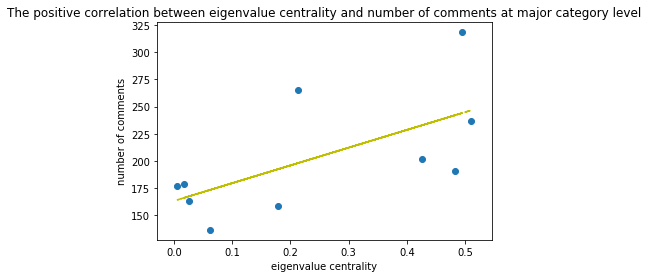

In [1308]:
plt.scatter(df_10['eigen_centrality'],df_10['comments'])
z = np.polyfit(df_10['eigen_centrality'], df_10['comments'], 1)
p = np.poly1d(z)
plt.plot(df_10['eigen_centrality'],p(df_10['eigen_centrality']),"y--")
plt.title('The positive correlation between eigenvalue centrality and number of comments at major category level')
plt.xlabel('eigenvalue centrality')
plt.ylabel('number of comments')
plt.show()

Next we turn to anther network metric of node centrality, the betweenness centrality, which measure the 'communication' position of the node with other nodes. 

In [1294]:
ser_bw =  pd.Series(nx.betweenness_centrality(g_cateogry_10,weight='weight'))
ser_bw.name = 'bw_centrality'
bw_centrality = pd.concat([ser_bw,pd.Series(labels,name="category")],axis=1)[['bw_centrality',"category"]].set_index("category")['bw_centrality'].to_dict()
sorted(bw_centrality.items(),key=lambda x:x[1],reverse=True)

[('7 space exploration and astronomy', 0.5509259259259258),
 ('9 entertainment and art', 0.40740740740740733),
 ('2 design and technology', 0.38888888888888884),
 ('1 mental health and personal growth', 0.2592592592592592),
 ('5 environment and nature', 0.2222222222222222),
 ('3 communication and society', 0.10185185185185186),
 ('8 global issues and politics', 0.10185185185185186),
 ('6 gender and culture', 0.07407407407407408),
 ('0 health science and medicine', 0.0),
 ('4 business and economics', 0.0)]

The top 2 categories stands out in the network as they are both positions as 'gateways' to the other cluster, and this time category ' business and economics' falls to the bottom since it is highly connected to other categories. So contrary to the 'closeness', it measures how 'loosely' the node is connected to other nodes in the network, and to some extent reflects the interdisciplinarity of the major category. Now we check any relationship with the average popularity.

In [1303]:
dataframe_10 = pd.concat([ser_bw,ser_popularity],axis=1)
dataframe_10['bw_centrality'].corr(dataframe_10['comments'])

-0.49189002640133006

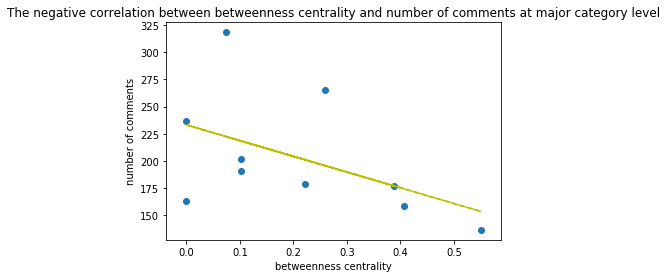

In [1310]:
plt.scatter(dataframe_10['bw_centrality'],dataframe_10['comments'])
z = np.polyfit(dataframe_10['bw_centrality'], dataframe_10['comments'], 1)
p = np.poly1d(z)
plt.plot(dataframe_10['bw_centrality'],p(dataframe_10['bw_centrality']),"y--",label='the trend line')
plt.title('The negative correlation between betweenness centrality and number of comments at major category level')
plt.xlabel('betweenness centrality')
plt.ylabel('number of comments')
plt.show()

They are negatively correlated with correlation coefficient -0.49189002640133006. Based on the above analysis, we can say TED talk viewers are less likely to give feedback on more interdisciplinary talks, which is a bit counter-intuitive, at least to me. 
One plausible explanation is that viewers are more willing to focus on what they are familiar with, and interdisciplinary talks tend to lead them away from their 'comfort zones' so they are reluctant to give opinions.

### Conclusions

1. Contrary to our expectation, we observe an overall trend of decreasing interdisciplinarity of TED talks in recent years. Several metrics of interdisciplinarity measured at different granularities confirm this trend. Can we generalize this result to other types of media or even to the academic world? Maybe not. Each nominated speaker candidate is selected by TED's speaker selection team based on the candidate's personal background and the talk topic(see [Speaker nomination form](https://speaker-nominations.ted.com/)), and the selection standards may be quite different from those for other types of media or the academic world.

2. We observe the major topic popularity measured by the average number of comments from TED talk online viewers is positively correlated with the eigenvector centrality of the major topic in the major topic network, which confirms "the rich gets richer" phenomenon since both the number of comments and the eigenvector centrality follow the Power Law to some extent. In contrast, the average number of comments is negatively related to the betweenness centrality at the major topic level. Since the betweenness centrality can be seen as another metric for the interdisciplinarity measured at the major topic level, we conclude that online viewers are less likely to make comments on talks with high interdisciplinarity. One plausible explanation is that viewers are more willing to focus on what they are familiar with, and interdisciplinary talks tend to lead them away from their 'comfort zones' so they are reluctant to give opinions. But viewers will also make comments out of curiosity and confusion which are more likely to arise when watching a TED talk of high interdisciplinarity. This interesting observation may be worth some further examinations. 

